In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path
from brian2 import *


# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)

restore_initial_state()

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2808 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:24 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:25 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [2]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from loguru import logger

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

def run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial=0):
    
    logger.info("Simulation configured:")
    logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

    # =============================================================================
    # RUN SINGLE SIMULATION
    # =============================================================================

    start_scope()

    # Create network
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=100,
        variable_seed=200+trial*3 + 1,
        trial=trial*3 + 1
    )
    pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])

    # Setup monitors and run
    network.setup_monitors(['A'], record_v_dt=0.1, sample_fraction=0.5)
    results = network.run_simulation()

    # Quick check
    logger.info(f"\n{'='*50}")
    logger.info("SIMULATION COMPLETED")
    logger.info(f"{'='*50}")
    logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
    logger.info(f"Recording shape: {results['A']['potentials'].shape}")

    return results, network, SIM_CONFIG

In [3]:
import numpy as np
from scipy import signal
from scipy.stats import pearsonr
from loguru import logger


def compute_cv_isi(spike_times, spike_indices, N_neurons, warmup=500, min_spikes=10):
    """
    Coeficiente de variación del ISI con warmup excluido.
    
    Returns NaN si no hay suficientes neuronas con spikes.
    """
    valid_spikes = spike_times >= warmup
    spike_times = spike_times[valid_spikes]
    spike_indices = spike_indices[valid_spikes]
    
    if len(spike_times) == 0:
        return np.nan
    
    cvs = []
    for n in range(N_neurons):
        neuron_spikes = spike_times[spike_indices == n]
        if len(neuron_spikes) >= min_spikes:
            isis = np.diff(neuron_spikes)
            cv = np.std(isis) / (np.mean(isis) + 1e-10)
            cvs.append(cv)
    
    return np.mean(cvs) if len(cvs) > 0 else np.nan


def compute_fano_factor(spike_times, T_total, window_ms=250, warmup=500):
    """
    Fano factor con warmup.
    """
    valid_spikes = spike_times[spike_times >= warmup]
    
    if len(valid_spikes) < 10:
        return np.nan
    
    bins = np.arange(warmup, T_total, window_ms)
    counts, _ = np.histogram(valid_spikes, bins=bins)
    
    mean_count = np.mean(counts)
    if mean_count < 0.1:
        return np.nan
    
    return np.var(counts) / mean_count


def compute_psd(spike_times, T_total, warmup=500, dt=1.0, fmax=100):
    """
    PSD con Welch method.
    """
    bins = np.arange(warmup, T_total, dt)
    counts, _ = np.histogram(spike_times, bins=bins)
    
    if len(counts) < 1024:
        logger.warning(f"PSD: only {len(counts)} bins, limited resolution")
        return np.array([]), np.array([])
    
    nperseg = 512
    fs = 1000.0 / dt
    freqs, psd = signal.welch(counts, fs=fs, nperseg=nperseg)
    
    mask = freqs <= fmax
    return freqs[mask], psd[mask]


def compute_sync_index(spike_times, spike_indices, warmup=500, 
                      N_sample=100, dt_bin=10, T_total=None):
    """
    Índice de sincronía por correlación cruzada.
    """
    if T_total is None:
        if len(spike_times) == 0:
            return np.nan
        T_total = spike_times.max() + dt_bin
    
    valid = spike_times >= warmup
    spike_times = spike_times[valid]
    spike_indices = spike_indices[valid]
    
    if len(spike_times) < 100:
        return np.nan
    
    bins = np.arange(warmup, T_total, dt_bin)
    neurons = np.unique(spike_indices)
    
    N_sample = min(N_sample, len(neurons))
    if N_sample < 10:
        return np.nan
    
    np.random.seed(42)
    sampled_neurons = np.random.choice(neurons, size=N_sample, replace=False)
    
    spike_trains = []
    for n in sampled_neurons:
        counts, _ = np.histogram(spike_times[spike_indices == n], bins=bins)
        spike_trains.append(counts)
    
    corrs = []
    for i in range(len(spike_trains)):
        for j in range(i+1, len(spike_trains)):
            std_i = np.std(spike_trains[i])
            std_j = np.std(spike_trains[j])
            
            if std_i > 0 and std_j > 0:
                r, _ = pearsonr(spike_trains[i], spike_trains[j])
                if np.isfinite(r):
                    corrs.append(r)
    
    return np.mean(corrs) if len(corrs) > 0 else np.nan

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
from src.two_populations.plots.basic_plots import plot_raster_results

Path("optimization_results").mkdir(exist_ok=True)

def plot_optimization_step(results, params, iteration, loss):
    rate, w_exc, w_inh = params
    Ne = 800
    Ni = 200

    plot_raster_results(results, Ne, 1000, 500)


    spike_times = results['A']['spike_times']
    spike_indices = results['A']['spike_indices']
    exc_mask = spike_indices < Ne
    inh_mask = ~exc_mask

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 2. Firing rate temporal
    ax2 = fig.add_subplot(gs[0, :])
    bins = np.arange(500, 4000, 5)
    times_exc = spike_times[exc_mask]
    times_inh = spike_times[inh_mask]
    counts_exc, _ = np.histogram(times_exc, bins=bins)
    counts_inh, _ = np.histogram(times_inh, bins=bins)
    delta_s = 0.005
    eps = 1e-8
    rate_exc = counts_exc / (delta_s * Ne + eps)
    rate_inh = counts_inh / (delta_s * Ni + eps)
    from scipy.ndimage import gaussian_filter1d
    rate_exc_smooth = gaussian_filter1d(rate_exc, sigma=2)
    rate_inh_smooth = gaussian_filter1d(rate_inh, sigma=2)
    ax2.plot(bins[:-1], rate_exc_smooth, label=f'Exc (μ={rate_exc.mean():.1f}Hz)', color='C0')
    ax2.plot(bins[:-1], rate_inh_smooth, label=f'Inh (μ={rate_inh.mean():.1f}Hz)', color='C1')
    ax2.axhline(7.5, color='C0', linestyle='--', alpha=0.3, label='Target Exc')
    ax2.axhline(10,  color='C1', linestyle='--', alpha=0.3, label='Target Inh')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. PSD
    ax3 = fig.add_subplot(gs[1, 0])
    try:
        freqs, psd = compute_psd(spike_times, 3000, warmup=500)
    except TypeError:
        freqs, psd = compute_psd(spike_times, 3000)
    if len(freqs) > 0 and np.all(np.isfinite(psd)):
        ax3.semilogy(freqs, psd, color='k', linewidth=1)
        ax3.axvspan(8, 12, alpha=0.2, color='blue', label='Alpha')
        ax3.axvspan(40, 80, alpha=0.2, color='red', label='Gamma')
        ax3.set_xlabel('Frequency (Hz)')
        ax3.set_ylabel('Power')
        ax3.set_xlim(0, 100)
        ax3.legend()
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, "PSD inválida", ha='center', va='center')
        ax3.axis('off')

    # 4. Métricas resumen (fila inferior)
    ax4 = fig.add_subplot(gs[1, 1])
    time_valid_s = (3000 - 500) / 1000.0
    fr_exc_tot = len(spike_times[exc_mask]) / (time_valid_s * Ne + eps)
    fr_inh_tot = len(spike_times[inh_mask]) / (time_valid_s * Ni + eps)
    ratio = fr_inh_tot / (fr_exc_tot + eps)
    cv = compute_cv_isi(spike_times, spike_indices, Ne + Ni, warmup=500)
    fano = compute_fano_factor(spike_times, 3000, 250, warmup=500)
    sync = compute_sync_index(spike_times, spike_indices, 500, 100, 1, 3000)
    if not np.isfinite(cv): cv = np.nan
    if not np.isfinite(fano): fano = np.nan
    if not np.isfinite(sync): sync = np.nan

    metrics_text = f"""
FR Exc: {fr_exc_tot:.2f} Hz (target: 7.5)
FR Inh: {fr_inh_tot:.2f} Hz (target: 10.0)
Ratio Inh/Exc: {ratio:.2f} (target: 1.3)
CV ISI: {cv:.2f}
Fano: {fano:.2f}
Sync: {sync:.3f} (limit: 0.3)
Loss: {loss:.2f}
    """
    ax4.text(0.05, 0.5, metrics_text, fontsize=11,
             verticalalignment='center', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax4.axis('off')

    fname = f'optimization_results/iter_{iteration:03d}.png'
    fig.savefig(fname, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)


In [5]:
# def objective_function(params, n_trials=1, iteration=[0]):
#     rate_hz, w_exc, w_inh = params

#     NETWORK_PARAMS = {
#         'pop_A': {
#             'Ne': 800, 'Ni': 200,
#             'k_exc': 1.0, 'k_inh': 3.9,
#             'noise_exc': w_exc,
#             'noise_inh': w_inh,
#             'p_intra': 0.1,
#             'delay': 0.0,
#             'rate_hz': rate_hz,
#         }
#     }

#     SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 3000, 'warmup_ms': 500}

#     losses = []
#     max_loss = 1e6

#     for trial in range(n_trials):
#         try:
#             results, _, _ = run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial=trial)

#             spike_times = results['A']['spike_times']
#             spike_indices = results['A']['spike_indices']
#             valid = spike_times >= SIM_CONFIG['warmup_ms']
#             spike_times = spike_times[valid]
#             spike_indices = spike_indices[valid]

#             Ne = NETWORK_PARAMS['pop_A']['Ne']
#             Ni = NETWORK_PARAMS['pop_A']['Ni']

#             total_spikes = len(spike_times)
            
#             # FILTRADO MEJORADO de casos extremos
#             if total_spikes < 100 or total_spikes > 100000:
#                 losses.append(500.0)
#                 continue

#             exc_mask = spike_indices < Ne
#             inh_mask = ~exc_mask

#             time_span_s = (SIM_CONFIG['T_ms'] - SIM_CONFIG['warmup_ms']) / 1000.0
#             eps = 1e-6
#             fr_exc = np.sum(exc_mask) / (time_span_s * Ne + eps)
#             fr_inh = np.sum(inh_mask) / (time_span_s * Ni + eps)
            
#             # FILTRO por firing rates
#             if fr_exc < 1.0 or fr_exc > 15.0 or fr_inh < 2.0 or fr_inh > 20.0:
#                 losses.append(300.0)
#                 continue

#             # 1. CÁLCULO MEJORADO de L_balance
#             target_ratio = 1.3
#             current_ratio = fr_inh / (fr_exc + eps)
#             if current_ratio > 0:
#                 log_diff = np.log(current_ratio) - np.log(target_ratio)
#                 L_balance = min(log_diff**2, 2.0)
#             else:
#                 L_balance = 10.0

#             # 2. PÉRDIDA por firing rates (existente)
#             L_fr = ((fr_exc - 6.5)/6.5)**2 + ((fr_inh - 8.5)/8.5)**2

#             # 3. MÉTRICAS de variabilidad (existente)
#             cv = compute_cv_isi(spike_times, spike_indices, Ne + Ni, SIM_CONFIG['warmup_ms'])
#             fano = compute_fano_factor(spike_times, SIM_CONFIG['T_ms'], window_ms=250, warmup=SIM_CONFIG['warmup_ms'])
            
#             if not np.isfinite(cv): cv = 10.0
#             if not np.isfinite(fano): fano = 10.0

#             # CV con ventanas de tolerancia
#             cv_target, cv_tol_low, cv_tol_high = 1.0, 0.8, 1.5
#             if cv < cv_tol_low:
#                 L_cv = ((cv - cv_tol_low)/cv_tol_low)**2
#             elif cv > cv_tol_high:
#                 L_cv = ((cv - cv_target)/(cv_tol_high - cv_tol_low))**2
#             else:
#                 L_cv = 0.0

#             # Fano con ventanas de tolerancia  
#             fano_target, fano_tol_low, fano_tol_high = 1.0, 0.8, 1.5
#             if fano < fano_tol_low:
#                 L_fano = ((fano - fano_tol_low)/fano_tol_low)**2
#             elif fano > fano_tol_high:
#                 L_fano = ((fano - fano_target)/(fano_tol_high - fano_tol_low))**2
#             else:
#                 L_fano = 0.0

#             # 4. DRIFT (existente)
#             mid_time = SIM_CONFIG['warmup_ms'] + (SIM_CONFIG['T_ms'] - SIM_CONFIG['warmup_ms'])/2
#             mask_first = (spike_times < mid_time) & exc_mask
#             mask_second = (spike_times >= mid_time) & exc_mask
#             fr_exc_first = np.sum(mask_first) / (((mid_time - SIM_CONFIG['warmup_ms'])/1000.0) * Ne + eps)
#             fr_exc_second = np.sum(mask_second) / (((SIM_CONFIG['T_ms'] - mid_time)/1000.0) * Ne + eps)
#             drift = abs(fr_exc_first - fr_exc_second) / ((fr_exc_first + fr_exc_second)/2 + eps)
#             L_drift = (drift / 0.2)**2

#             # 5. ESPECTRO de potencias (existente con ajustes)
#             freqs, psd = compute_psd(spike_times, SIM_CONFIG['T_ms'], SIM_CONFIG['warmup_ms'], 1, 100)
#             if len(freqs) == 0 or not np.all(np.isfinite(psd)):
#                 losses.append(max_loss)
#                 continue

#             total_mask = (freqs >= 0) & (freqs <= 100)
#             total_power = np.trapz(psd[total_mask], freqs[total_mask]) + eps

#             # Bandas espectrales con tolerancias relajadas
#             beta_mask = (freqs >= 15) & (freqs <= 30)
#             alpha_mask = (freqs >= 8) & (freqs <= 13)
#             gamma_mask = (freqs >= 40) & (freqs <= 80)

#             beta_power = np.trapezoid(psd[beta_mask], freqs[beta_mask])
#             alpha_power = np.trapezoid(psd[alpha_mask], freqs[alpha_mask])
#             gamma_power = np.trapezoid(psd[gamma_mask], freqs[gamma_mask])

#             beta_ratio = beta_power / (total_power + eps)
#             alpha_ratio = alpha_power / (total_power + eps) 
#             gamma_ratio = gamma_power / (total_power + eps)

#             # Asegurar valores finitos
#             alpha_ratio = alpha_ratio if np.isfinite(alpha_ratio) and alpha_ratio >= 0 else 0.0
#             gamma_ratio = gamma_ratio if np.isfinite(gamma_ratio) and gamma_ratio >= 0 else 0.0
#             beta_ratio = beta_ratio if np.isfinite(beta_ratio) and beta_ratio >= 0 else 0.0

#             # Penalizaciones espectrales RELAJADAS
#             beta_target, beta_tol = 0.15, 0.10
#             L_beta = ((max(0, beta_ratio - beta_target)) / beta_tol)**2 if beta_ratio > beta_target else 0.0

#             alpha_target, alpha_tol = 0.10, 0.05
#             L_alpha = ((max(0, alpha_ratio - alpha_target)) / alpha_tol)**2 if alpha_ratio > alpha_target else 0.0

#             gamma_target, gamma_tol = 0.20, 0.10  
#             L_gamma = ((max(0, gamma_ratio - gamma_target)) / gamma_tol)**2 if gamma_ratio > gamma_target else 0.0

#             # 6. SINCRONIZACIÓN (existente)
#             sync = compute_sync_index(spike_times, spike_indices, SIM_CONFIG['warmup_ms'], 100, 5, SIM_CONFIG['T_ms'])
#             if not np.isfinite(sync): sync = 1.0
#             L_sync = max(0, sync - 0.2)**2

#             logger.info(f"{L_fr=:.3f}, {L_balance=:.3f}, {L_cv=:.3f}, {L_fano=:.3f}, {L_drift=:.3f}, {L_alpha=:.3f}, {L_gamma=:.3f}, {L_beta=:.3f}, {L_sync=:.3f}")

#             # 7. PÉRDIDA FINAL con pesos OPTIMIZADOS
#             loss = (1.5 * L_fr
#                     + 1.0 * L_balance    # Reducido
#                     + 1.0 * L_cv
#                     + 0.8 * L_fano
#                     + 0.5 * L_drift      # Reducido
#                     + 0.8 * L_alpha
#                     + 0.8 * L_gamma
#                     + 0.3 * L_beta
#                     + 1.0 * L_sync)      # Reducido

#             # 8. PENALIZACIÓN MEJORADA por firing rates extremos
#             # PENALIZACIÓN gradual por rates extremos
#             fr_penalty = 0.0
#             if fr_exc < 3.0 or fr_exc > 10.0:
#                 exc_dev = max(3.0 - fr_exc, fr_exc - 10.0, 0)
#                 fr_penalty += (exc_dev / 3.0)**2
#             if fr_inh < 5.0 or fr_inh > 12.0:
#                 inh_dev = max(5.0 - fr_inh, fr_inh - 12.0, 0)
#                 fr_penalty += (inh_dev / 4.0)**2
            
#             loss += 50.0 * fr_penalty

#             loss = np.clip(loss, 0, max_loss)
#             losses.append(loss)
            
#             # LOGGING MEJORADO
#             logger.info(f"Rates: exc={fr_exc:.1f}, inh={fr_inh:.1f}, ratio={current_ratio:.2f}")
#             logger.info(f"{L_fr=:.3f}, {L_balance=:.3f}, {L_beta=:.3f}")

#         except Exception as e:
#             logger.error(f"Trial {trial} failed: {e}")
#             losses.append(max_loss)

#     mean_loss = np.mean(losses)
#     logger.info(f"[Opt] params: rate={rate_hz:.2f}, w_exc={w_exc:.3f}, w_inh={w_inh:.3f} → "
#                                                                     f"loss={mean_loss:.3f}")
#     return mean_loss

In [6]:
# =============================================================================
# OPTIMIZATION SETUP
# =============================================================================
from skopt import gp_minimize
import numpy as np

def objective_function(params, n_trials=1, iteration=[0]):
    rate_hz, w_exc, w_inh = params
    k_factor = 4.0
    
    NETWORK_PARAMS = {
        'pop_A': {
            'Ne': 800, 'Ni': 200,
            'k_exc': k_factor, 'k_inh': k_factor*3.9,
            'noise_exc': w_exc,
            'noise_inh': w_inh,
            'p_intra': 0.1,
            'delay': 0.0,
            'rate_hz': rate_hz,
        }
    }

    SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 2500, 'warmup_ms': 500}

    losses = []
    max_loss = 1e6  # umbral máximo de pérdida

    for trial in range(n_trials):
        try:
            results, _, _ = run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial=trial)

            spike_times = results['A']['spike_times']
            spike_indices = results['A']['spike_indices']
            valid = spike_times >= SIM_CONFIG['warmup_ms']
            spike_times = spike_times[valid]
            spike_indices = spike_indices[valid]

            Ne = NETWORK_PARAMS['pop_A']['Ne']
            Ni = NETWORK_PARAMS['pop_A']['Ni']

            total_spikes = len(spike_times)
            if total_spikes < 10:
                losses.append(max_loss)
                continue

            exc_mask = spike_indices < Ne
            inh_mask = ~exc_mask

            time_span_s = (SIM_CONFIG['T_ms'] - SIM_CONFIG['warmup_ms']) / 1000.0
            eps = 1e-6
            fr_exc = np.sum(exc_mask) / (time_span_s * Ne + eps)
            fr_inh = np.sum(inh_mask) / (time_span_s * Ni + eps)

            # tasas idealizadas
            L_fr = ((fr_exc - 5.0)/5.0)**2 + ((fr_inh - 7.0)/7.0)**2

            ratio = fr_inh / (fr_exc + eps)
            L_balance = (np.log(ratio + eps) - np.log(1.3))**2

            cv = compute_cv_isi(spike_times, spike_indices, Ne + Ni, SIM_CONFIG['warmup_ms'])
            fano = compute_fano_factor(spike_times, SIM_CONFIG['T_ms'], window_ms=250, warmup=SIM_CONFIG['warmup_ms'])
            if not np.isfinite(cv):
                cv = 10.0
            if not np.isfinite(fano):
                fano = 10.0
            L_cv = ((cv - 1.0)/1.0)**2
            L_fano = ((fano - 1.0)/1.0)**2

            # drift
            mid_time = SIM_CONFIG['warmup_ms'] + (SIM_CONFIG['T_ms'] - SIM_CONFIG['warmup_ms'])/2
            mask_first = (spike_times < mid_time) & exc_mask
            mask_second = (spike_times >= mid_time) & exc_mask
            fr_exc_first = np.sum(mask_first) / (((mid_time - SIM_CONFIG['warmup_ms'])/1000.0) * Ne + eps)
            fr_exc_second = np.sum(mask_second) / (((SIM_CONFIG['T_ms'] - mid_time)/1000.0) * Ne + eps)
            drift = abs(fr_exc_first - fr_exc_second) / ( (fr_exc_first + fr_exc_second)/2 + eps )
            L_drift = (drift / 0.2)**2

            freqs, psd = compute_psd(spike_times, SIM_CONFIG['T_ms'], SIM_CONFIG['warmup_ms'], 1, 100)
            if len(freqs) == 0 or not np.all(np.isfinite(psd)):
                losses.append(max_loss)
                continue

            alpha_mask = (freqs >= 8) & (freqs <= 12)
            gamma_mask = (freqs >= 40) & (freqs <= 80)
            total_mask = (freqs >= 0) & (freqs <= 100)

            alpha_power = np.trapezoid(psd[alpha_mask], freqs[alpha_mask])
            gamma_power = np.trapezoid(psd[gamma_mask], freqs[gamma_mask])
            total_power = np.trapezoid(psd[total_mask], freqs[total_mask]) + 1e-12

            alpha_ratio = alpha_power / total_power
            gamma_ratio = gamma_power / total_power
            if not np.isfinite(alpha_ratio) or alpha_ratio < 0:
                alpha_ratio = 0.0
            if not np.isfinite(gamma_ratio) or gamma_ratio < 0:
                gamma_ratio = 0.0

            L_alpha = (max(0, 0.15 - alpha_ratio))**2 / (0.07**2)
            L_gamma = (max(0, 0.3 - gamma_ratio))**2 / (0.15**2)

            sync = compute_sync_index(spike_times, spike_indices, SIM_CONFIG['warmup_ms'], 100, 5, SIM_CONFIG['T_ms'])
            if not np.isfinite(sync):
                sync = 1.0
            L_sync = max(0, sync - 0.3)**2

            logger.info(f"{L_fr=}, {L_balance=}, {L_cv=}, {L_fano=}, {L_drift=}, {L_alpha=}, {L_gamma=}, {L_sync=}")
            
            loss = (1.5 * L_fr + 1.5 * L_balance + 1.0 * L_cv + 1.5 * L_fano +
                    1.0 * L_drift + 1.0 * L_alpha + 1.25 * L_gamma + 1.25 * L_sync)

            if fr_exc < 2.0 or fr_exc > 20.0 or fr_inh < 3.0 or fr_inh > 25.0:
                loss += 100.0

            # Clip final loss
            loss = np.clip(loss, 0, max_loss)
            
            # if loss < 5.0:
            #     if trial == 0:
            #         plot_optimization_step(results, params, iteration[0], loss)

            losses.append(loss)

        except Exception as e:
            logger.error(f"Trial {trial} failed: {e}")
            losses.append(max_loss)

    mean_loss = np.mean(losses)
    logger.info(f"[Stable] params: rate={rate_hz:.2f}, w_exc={w_exc:.3f}, w_inh={w_inh:.3f} → loss={mean_loss:.3f}")
    return mean_loss

In [7]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.callbacks import VerboseCallback, DeltaYStopper
import numpy as np

def adaptive_gp_minimize_my(
    objective_fn,
    initial_bounds,
    n_phases=5,
    calls_per_phase=15,
    shrink_factor=0.25,
    gp_kwargs=None
):
    """
    Versión adaptativa de búsqueda para tu caso concreto,
    con estrechamiento del rango alrededor del mejor punto.

    :param objective_fn: tu función objetivo que toma `params`
    :param initial_bounds: lista de (low, high) para cada parámetro
    :param n_phases: cuántas fases adaptativas
    :param calls_per_phase: número de evaluaciones por fase
    :param shrink_factor: cuánto reducir el rango (por ejemplo 0.5 para mitad del radio)
    :param gp_kwargs: dict con argumentos adicionales para gp_minimize
    :returns: (mejor_x, mejor_fun)
    """
    if gp_kwargs is None:
        gp_kwargs = {}
    # Copia mutable de bounds
    current_bounds = [list(b) for b in initial_bounds]

    best_x = None
    best_fun = np.inf
    results = []
    
    for phase in range(n_phases):
        print(f"\n--- Fase {phase+1}/{n_phases}, bounds = {current_bounds} ---")

        # definir dimensiones para esta fase
        dimensions = [
            Real(low, high, prior="log-uniform") for (low, high) in current_bounds
        ]

        # callbacks adaptados
        cb = [
            VerboseCallback(n_total=calls_per_phase),
            DeltaYStopper(delta=0.1, n_best=5)
        ]
        
        # decidir x0 para esta fase
        if phase == 0:
            x0 = None #[[10.106089400313447, 0.8841317789250513, 0.6041873715553614]] #[[3.0752934569435175, 2.773154042908913, 1.3215446209574226]] # [(7.970982780271352, 8.0), (0.8942958452407234, 0.8981393910549135), (0.6068017774108528, 0.6129305172704455)] [[2.418700129545733, 0.4547417710544537, 0.262135421946403]] #[[2.0, 0.5, 0.3]]  # punto conocido en la fase inicial
        else:
            # usar el mejor de la fase anterior o dejar None para explorar libremente
            if best_x is not None:
                x0 = [best_x]
            else:
                x0 = None

        # llamar a gp_minimize para esta fase
        res = gp_minimize(
            objective_fn,
            dimensions=dimensions,
            n_calls=calls_per_phase,
            x0=x0,
            callback=cb,
            **gp_kwargs
        )

        print(f"→ Mejor de fase {phase+1}: x = {res.x}, loss = {res.fun:.4f}")

        # si mejora, actualizar global
        if res.fun < best_fun:
            best_fun = res.fun
            best_x = res.x

        # Si no encontramos un punto mejor, podemos frenar
        if best_x is None:
            break

        # calcular nuevos bounds alrededor del best_x
        new_bounds = []
        for i, (low, high) in enumerate(current_bounds):
            center = best_x[i]
            span = high - low
            new_radius = span * shrink_factor / 2.0
            new_low = max(center - new_radius, low)
            new_high = min(center + new_radius, high)
            new_bounds.append((new_low, new_high))
        current_bounds = new_bounds
        results.append(res)
        
    print("\n=== Resultado final adaptativo ===")
    print("Mejor x:", best_x)
    print("Mejor loss:", best_fun)
    return best_x, best_fun, results


# -----------------------------------------------------------
# Ejemplo de uso con tu función objective_function original

for t in range(2):

    initial_bounds = [
        (2.5, 20.0),   # rate_hz
        (0.4, 1.2),   # w_exc
        (0.2, 1.2),   # w_inh
    ]

    gp_kwargs = {
        "acq_func": "gp_hedge", # "acq_func": "EI", 
        "xi": 0.05, #  "xi": 0.01,
        "acq_optimizer": "lbfgs",
        "n_restarts_optimizer": 15, # "n_restarts_optimizer": 10,
        "noise": 0.2,
        "random_state": 42+t,
        "n_jobs":-1,
        "verbose": True,
        "initial_point_generator": 'lhs'
    }


    best_x, best_loss, results = adaptive_gp_minimize_my(
        objective_function,
        initial_bounds,
        n_phases=6,
        calls_per_phase=15,
        shrink_factor=0.8,
        gp_kwargs=gp_kwargs
    )

    print("Parámetros óptimos adaptativos:", best_x)
    print("Pérdida óptima adaptativa:", best_loss)

INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 200, 'variable_base_B': 202, 'variable_base_common': 201, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}



--- Fase 1/6, bounds = [[2.5, 20.0], [0.4, 1.2], [0.2, 1.2]] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at random point.


INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 200
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 16.159585106568105Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 20269 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.8837710166367767), L_balance=np.float64(1.335037950070775), L_cv=np.float64(0.23524030653341987), L_fano=np.float64(147.16191602251735), L_drift=np.float64(0.02216625045853376), L_alpha=np.float64(1.4643430537209536), L_gamma=np.float64(2.27099

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 34.0531
Function value obtained: 233.1316
Current minimum: 233.1316
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 33.9278
Function value obtained: 233.1316
Current minimum: 233.1316
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 43 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9878940051322136), L_balance=np.float64(108.05384388987261), L_cv=81.0, L_fano=np.float64(0.32653061224489793), L_drift=np.float64(0.0), L_alpha=np.float64(3.4201391687340514), L_gamma=0.0, L_sync=0.48999999999999994
INFO     | __main__:objective_function:128 - [Stable] params: rate=3.37, w_exc=0.730, w_inh=0.260 → loss=350.585
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_commo

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 30.6948
Function value obtained: 350.5850
Current minimum: 233.1316
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 30.6951
Function value obtained: 350.5850
Current minimum: 233.1316
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 19940 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.951414767575821), L_balance=np.float64(1.4922148165817617), L_cv=np.float64(0.21266329698925274), L_fano=np.float64(363.68764910141675), L_drift=np.float64(0.7251689094043081), L_alpha=np.float64(1.799923160681596), L_gamma=np.float64(2.0171193046302416), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.55, w_exc=0.868, w_inh=1.148 → loss=558.956
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 27.2463
Function value obtained: 558.9561
Current minimum: 233.1316
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 27.2466
Function value obtained: 558.9561
Current minimum: 233.1316
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 1205 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.4596753186748543), L_balance=np.float64(10.524690732349175), L_cv=np.float64(0.3338580672229323), L_fano=np.float64(0.10774770093023045), L_drift=np.float64(0.1537821804212383), L_alpha=np.float64(4.202050981244884), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=4.84, w_exc=0.827, w_inh=0.508 → loss=122.828
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B'

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 29.8293
Function value obtained: 122.8279
Current minimum: 122.8279
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 29.8295
Function value obtained: 122.8279
Current minimum: 122.8279
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 1321 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.3901787001519126), L_balance=np.float64(210.80656216666105), L_cv=np.float64(0.3143771815517513), L_fano=np.float64(0.4259664650173795), L_drift=np.float64(0.0), L_alpha=np.float64(4.216615555711408), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=3.05, w_exc=0.421, w_inh=0.834 → loss=423.465
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_se

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 29.1154
Function value obtained: 423.4651
Current minimum: 122.8279
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 29.1155
Function value obtained: 423.4651
Current minimum: 122.8279
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 3800 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.793417415049171), L_balance=np.float64(0.8351618590776966), L_cv=np.float64(0.20129336634465203), L_fano=np.float64(23536.76505095984), L_drift=np.float64(0.03877476267199281), L_alpha=np.float64(1.208915162000112), L_gamma=np.float64(3.7040376887932855), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.05, w_exc=0.643, w_inh=0.345 → loss=35413.669
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 27.9943
Function value obtained: 35413.6695
Current minimum: 122.8279
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 27.9944
Function value obtained: 35413.6695
Current minimum: 122.8279
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 3643 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0015433671427934), L_balance=np.float64(241.41670624161162), L_cv=np.float64(0.24641738759322512), L_fano=np.float64(0.7393328171098762), L_drift=np.float64(0.0), L_alpha=np.float64(4.4277569812489865), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.80, w_exc=0.576, w_inh=0.925 → loss=469.411
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 27.9915
Function value obtained: 469.4105
Current minimum: 122.8279
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 27.9915
Function value obtained: 469.4105
Current minimum: 122.8279
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 17152 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.133138071346916), L_balance=np.float64(0.007414089571086715), L_cv=np.float64(0.2260542705686237), L_fano=np.float64(9746.144059980317), L_drift=np.float64(0.4967494268752743), L_alpha=np.float64(1.6536361968895974), L_gamma=np.float64(2.1296370831622644), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=4.22, w_exc=1.187, w_inh=0.210 → loss=14624.465
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 24.9241
Function value obtained: 14624.4654
Current minimum: 122.8279
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 24.9241
Function value obtained: 14624.4654
Current minimum: 122.8279
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 42074 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(9.8289066368187), L_balance=np.float64(0.055828936965377295), L_cv=np.float64(0.3080249303573088), L_fano=np.float64(13.725319132987622), L_drift=np.float64(0.003486420181082), L_alpha=np.float64(0.88547044639173), L_gamma=np.float64(0.11144532178054317), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.41, w_exc=1.012, w_inh=0.478 → loss=36.751
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_se

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 28.2301
Function value obtained: 36.7514
Current minimum: 36.7514
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 28.2301
Function value obtained: 36.7514
Current minimum: 36.7514
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22151 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.311774605708223), L_balance=np.float64(0.17994445918625296), L_cv=np.float64(0.2625303227885378), L_fano=np.float64(1335.7564517517603), L_drift=np.float64(7.457319686893881e-05), L_alpha=np.float64(2.9435833286976174), L_gamma=np.float64(2.0255435145094087), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.38, w_exc=0.482, w_inh=0.322 → loss=2011.610
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 30.5133
Function value obtained: 2011.6104
Current minimum: 36.7514
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 30.5137
Function value obtained: 2011.6104
Current minimum: 36.7514
Iteration No: 11 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 68 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9739510829719347), L_balance=np.float64(16.10819980025765), L_cv=81.0, L_fano=np.float64(0.007061648188687227), L_drift=np.float64(99.84019179520507), L_alpha=np.float64(3.7465996759443874), L_gamma=0.0, L_sync=0.48999999999999994
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.28, w_exc=0.628, w_inh=0.207 → loss=312.333
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fi

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 27.7959
Function value obtained: 312.3331
Current minimum: 36.7514
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 27.7959
Function value obtained: 312.3331
Current minimum: 36.7514
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 7505 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1464489599362588), L_balance=np.float64(5.3544411976952455), L_cv=np.float64(0.22111833563545022), L_fano=np.float64(518.2465334019028), L_drift=np.float64(1.4979820077733854), L_alpha=np.float64(2.449335529425398), L_gamma=np.float64(0.08505943485946137), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.58, w_exc=0.584, w_inh=0.726 → loss=891.396
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 28.7682
Function value obtained: 891.3959
Current minimum: 36.7514
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 28.7683
Function value obtained: 891.3959
Current minimum: 36.7514
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 3758 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0025527100801315), L_balance=np.float64(46.6109219251701), L_cv=np.float64(0.2419575004121522), L_fano=np.float64(0.8409563387248745), L_drift=np.float64(15.994881228531515), L_alpha=np.float64(4.4018178179617085), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.11, w_exc=0.696, w_inh=1.041 → loss=193.320
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 25.3348
Function value obtained: 193.3203
Current minimum: 36.7514
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 25.3350
Function value obtained: 193.3203
Current minimum: 36.7514
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 3080 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0112215008961771), L_balance=np.float64(32.497260049375924), L_cv=np.float64(0.2582915509995531), L_fano=np.float64(0.699104415882435), L_drift=np.float64(0.15997952196588647), L_alpha=np.float64(4.233471156710246), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.14, w_exc=0.739, w_inh=0.894 → loss=155.963
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B':

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 28.2665
Function value obtained: 155.9631
Current minimum: 36.7514
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 28.2666
Function value obtained: 155.9631
Current minimum: 36.7514
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 26665 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(5.293570881491305), L_balance=np.float64(0.6564662232085176), L_cv=np.float64(0.26468933523645705), L_fano=np.float64(28.724552305731393), L_drift=np.float64(0.006641860289378494), L_alpha=0.0, L_gamma=np.float64(1.9021380007610267), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.08, w_exc=0.942, w_inh=1.010 → loss=54.661
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 28.4110
Function value obtained: 54.6609
Current minimum: 36.7514
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 28.4111
Function value obtained: 54.6609
Current minimum: 36.7514
→ Mejor de fase 1: x = [12.414973680528343, 1.0121223508933122, 0.4777794404598472], loss = 36.7514

--- Fase 2/6, bounds = [(5.414973680528343, 19.41497368052834), (0.6921223508933121, 1.2), (0.2, 0.8777794404598472)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 12.414973680528343Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 42428 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.031968934329406), L_balance=np.float64(0.052544396974652095), L_cv=np.float64(0.30688142402217705), L_fano=np.float64(2.4517414498192713), L_drift=np.float64(0.03141803475744691), L_alpha=np.float64(1.8351403425603094), L_gamma=np.float64(0.2272833978480732), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.41, w_exc

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 28.2603
Function value obtained: 21.2619
Current minimum: 21.2619
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 28.1889
Function value obtained: 21.2619
Current minimum: 21.2619
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25341 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.225961629209871), L_balance=np.float64(0.1264548834929155), L_cv=np.float64(0.2825430519327748), L_fano=np.float64(164.38150795814454), L_drift=np.float64(0.022683041925395168), L_alpha=np.float64(0.6248737833972837), L_gamma=np.float64(1.9223958355214983), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.72, w_exc=0.808, w_inh=0.512 → loss=253.434
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixe

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 24.9577
Function value obtained: 253.4340
Current minimum: 21.2619
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 24.9580
Function value obtained: 253.4340
Current minimum: 21.2619
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40063 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(9.796235418843592), L_balance=np.float64(0.13670481922781608), L_cv=np.float64(0.30039522246637274), L_fano=np.float64(2.173912191443131), L_drift=np.float64(0.0014066404979751668), L_alpha=np.float64(0.10339961811176472), L_gamma=np.float64(0.5204229741923191), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.36, w_exc=1.099, w_inh=0.701 → loss=119.216
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 28.1249
Function value obtained: 119.2160
Current minimum: 21.2619
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 28.1251
Function value obtained: 119.2160
Current minimum: 21.2619
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 37618 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.4746898423901005), L_balance=np.float64(0.018175892854258933), L_cv=np.float64(0.3091988223253281), L_fano=np.float64(2.7987934801152394), L_drift=np.float64(0.008580500306505314), L_alpha=np.float64(0.05444322976888258), L_gamma=np.float64(0.5935167628569458), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.34, w_exc=0.795, w_inh=0.275 → loss=15.052
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 28.1779
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 28.1780
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23511 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.6527014537296636), L_balance=np.float64(0.1407294052698801), L_cv=np.float64(0.2652783363223327), L_fano=np.float64(620.0885792152852), L_drift=np.float64(0.10484675030125333), L_alpha=np.float64(2.0708568675988834), L_gamma=np.float64(2.348303192143625), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.44, w_exc=0.961, w_inh=0.619 → loss=938.199
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 20.7030
Function value obtained: 938.1994
Current minimum: 15.0516
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 20.7030
Function value obtained: 938.1994
Current minimum: 15.0516
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 521 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.744080615696652), L_balance=np.float64(13.528842837424323), L_cv=np.float64(0.3799560796956494), L_fano=np.float64(0.17076438925661233), L_drift=np.float64(1.0700365016328564), L_alpha=np.float64(3.9150500561587016), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.51, w_exc=0.721, w_inh=0.341 → loss=128.531
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B':

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 11.8731
Function value obtained: 128.5306
Current minimum: 15.0516
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.8731
Function value obtained: 128.5306
Current minimum: 15.0516
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25838 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.4645698235953342), L_balance=np.float64(0.00010759221332233547), L_cv=np.float64(0.26922916892848725), L_fano=np.float64(193.1544633814185), L_drift=np.float64(0.09514533754468771), L_alpha=np.float64(0.4716877207337209), L_gamma=np.float64(1.6641882415121645), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.83, w_exc=0.884, w_inh=0.214 → loss=294.845
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 12.3373
Function value obtained: 294.8450
Current minimum: 15.0516
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.3373
Function value obtained: 294.8450
Current minimum: 15.0516
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 16086 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.8333786592284802), L_balance=np.float64(1.2735496288367016), L_cv=np.float64(0.19285349724825257), L_fano=np.float64(1098.0339064068214), L_drift=np.float64(0.10553034793071203), L_alpha=np.float64(1.043569296400843), L_gamma=np.float64(1.9312596938962145), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.55, w_exc=0.737, w_inh=0.867 → loss=1655.467
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 15.1744
Function value obtained: 1655.4673
Current minimum: 15.0516
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 15.1745
Function value obtained: 1655.4673
Current minimum: 15.0516
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 59043 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(21.302052417685736), L_balance=np.float64(5.3356662697581546e-06), L_cv=np.float64(0.2943360298329741), L_fano=np.float64(1.556540469909555), L_drift=np.float64(0.0031774804565347027), L_alpha=np.float64(3.9862995655919296), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.78, w_exc=1.034, w_inh=0.232 → loss=138.572
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 12.3451
Function value obtained: 138.5717
Current minimum: 15.0516
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.3451
Function value obtained: 138.5717
Current minimum: 15.0516
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23409 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1630888307468688), L_balance=np.float64(0.016949295338809463), L_cv=np.float64(0.28389268950513924), L_fano=np.float64(60.46107115674761), L_drift=np.float64(0.10752151231377706), L_alpha=np.float64(0.7857350737424104), L_gamma=np.float64(1.6897931000639743), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=6.35, w_exc=1.017, w_inh=0.352 → loss=95.751
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 12.2605
Function value obtained: 95.7511
Current minimum: 15.0516
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.2605
Function value obtained: 95.7511
Current minimum: 15.0516
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 54986 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(18.938879582689403), L_balance=np.float64(0.014307822273724152), L_cv=np.float64(0.2953578551466007), L_fano=np.float64(1.0091643603909852), L_drift=np.float64(8.282627053024654e-05), L_alpha=np.float64(4.261334318084102), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.28, w_exc=1.166, w_inh=0.431 → loss=134.500
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 16.0590
Function value obtained: 134.5003
Current minimum: 15.0516
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 16.0591
Function value obtained: 134.5003
Current minimum: 15.0516
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 46232 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.53075269918602), L_balance=np.float64(0.00586795134845056), L_cv=np.float64(0.31049711524775925), L_fano=np.float64(22.035582489328494), L_drift=np.float64(0.011784329447011115), L_alpha=np.float64(2.884376614530203), L_gamma=np.float64(0.10932470085512376), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=19.41, w_exc=0.692, w_inh=0.200 → loss=53.702
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.0681
Function value obtained: 53.7016
Current minimum: 15.0516
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.0682
Function value obtained: 53.7016
Current minimum: 15.0516
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 54079 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(18.48752822328303), L_balance=np.float64(0.02134682758851933), L_cv=np.float64(0.30089324734818845), L_fano=np.float64(0.033829754491048254), L_drift=np.float64(0.013002136413112174), L_alpha=np.float64(3.8662407598295694), L_gamma=np.float64(0.19638127504064265), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=19.41, w_exc=0.867, w_inh=0.344 → loss=132.240
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1,

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 16.0036
Function value obtained: 132.2397
Current minimum: 15.0516
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 16.0037
Function value obtained: 132.2397
Current minimum: 15.0516
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 44851 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.037217198142518), L_balance=np.float64(0.022473791721916256), L_cv=np.float64(0.30901587788232593), L_fano=np.float64(0.30960716857183346), L_drift=np.float64(0.005792821700560589), L_alpha=np.float64(1.5357820923818257), L_gamma=np.float64(0.7354390003813762), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=19.41, w_exc=0.692, w_inh=0.263 → loss=19.824
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.3459
Function value obtained: 19.8238
Current minimum: 15.0516
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.3460
Function value obtained: 19.8238
Current minimum: 15.0516
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 44833 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.060857760495464), L_balance=np.float64(0.02293078100857559), L_cv=np.float64(0.3131135859063683), L_fano=np.float64(1.4896415321908756), L_drift=np.float64(0.015443489456056605), L_alpha=np.float64(3.5413172902460963), L_gamma=np.float64(0.06236173712993543), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=19.41, w_exc=0.692, w_inh=0.264 → loss=22.808
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.2549
Function value obtained: 22.8080
Current minimum: 15.0516
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.2549
Function value obtained: 22.8080
Current minimum: 15.0516
→ Mejor de fase 2: x = [13.338994619815194, 0.7947150410300986, 0.2752016317057353], loss = 15.0516

--- Fase 3/6, bounds = [(7.738994619815195, 18.938994619815194), (0.6921223508933121, 0.9978661006727738), (0.2, 0.5463134078896742)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 37618 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.4746898423901005), L_balance=np.float64(0.018175892854258933), L_cv=np.float64(0.3091988223253281), L_fano=np.float64(2.7987934801152394), L_drift=np.float64(0.008580500306505314), L_alpha=np.float64(0.05444322976888258), L_gamma=np.float64(0.5935167628569458), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.34, w_exc=0.795, w_inh=0.275 → loss=15.052
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 12.7607
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 12.7220
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30910 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.838483976643519), L_balance=np.float64(0.05874126763203944), L_cv=np.float64(0.2910770880320842), L_fano=np.float64(284.0942214382275), L_drift=np.float64(0.008908159825154225), L_alpha=0.0, L_gamma=np.float64(1.60949071344416), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.66, w_exc=0.767, w_inh=0.379 → loss=434.299
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 12.6363
Function value obtained: 434.2990
Current minimum: 15.0516
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.6368
Function value obtained: 434.2990
Current minimum: 15.0516
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40657 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(9.183364756238293), L_balance=np.float64(0.06740645771913992), L_cv=np.float64(0.3107409674449665), L_fano=np.float64(3.2846162096923956), L_drift=np.float64(0.044624809389226486), L_alpha=np.float64(0.7512266113227897), L_gamma=np.float64(0.14436277411797024), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.01, w_exc=0.941, w_inh=0.469 → loss=20.090
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 15.7862
Function value obtained: 20.0901
Current minimum: 15.0516
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.7861
Function value obtained: 20.0901
Current minimum: 15.0516
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39436 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.439899716880997), L_balance=np.float64(0.009974852104644542), L_cv=np.float64(0.3023935801208695), L_fano=np.float64(24.485747622503723), L_drift=np.float64(0.017168079435850307), L_alpha=0.0, L_gamma=np.float64(0.9681797888425242), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.56, w_exc=0.759, w_inh=0.248 → loss=49.433
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 13.0526
Function value obtained: 49.4332
Current minimum: 15.0516
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.0526
Function value obtained: 49.4332
Current minimum: 15.0516
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28588 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.9020281444080953), L_balance=np.float64(0.07291027309367237), L_cv=np.float64(0.2956381934988913), L_fano=np.float64(71.585937579582), L_drift=np.float64(0.004949906761057094), L_alpha=0.0, L_gamma=np.float64(1.1721406502044045), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.67, w_exc=0.861, w_inh=0.431 → loss=113.607
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 15.6940
Function value obtained: 113.6071
Current minimum: 15.0516
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.6940
Function value obtained: 113.6071
Current minimum: 15.0516
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 13437 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.006096390787317036), L_balance=np.float64(0.019241748188375235), L_cv=np.float64(0.1072108994840006), L_fano=np.float64(3857.589524092972), L_drift=np.float64(1.0724732881867434), L_alpha=np.float64(1.1302176941739814), L_gamma=np.float64(2.426524895160652), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.83, w_exc=0.711, w_inh=0.287 → loss=5791.765
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 12.8463
Function value obtained: 5791.7654
Current minimum: 15.0516
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.8468
Function value obtained: 5791.7654
Current minimum: 15.0516
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30530 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.104787737931834), L_balance=np.float64(0.0027540737957866884), L_cv=np.float64(0.29837105016076865), L_fano=np.float64(128.70470765226435), L_drift=np.float64(0.02377301682821329), L_alpha=0.0, L_gamma=np.float64(1.8563398513820546), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.02, w_exc=0.814, w_inh=0.210 → loss=200.361
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 12.6100
Function value obtained: 200.3609
Current minimum: 15.0516
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.6104
Function value obtained: 200.3609
Current minimum: 15.0516
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25636 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.5952275343312996), L_balance=np.float64(0.22764121749851196), L_cv=np.float64(0.26918933918957083), L_fano=np.float64(5.989220060458056), L_drift=np.float64(0.007305133742135122), L_alpha=np.float64(1.2649773751845472), L_gamma=np.float64(1.9318326979261078), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.52, w_exc=0.722, w_inh=0.542 → loss=17.174
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 15.7747
Function value obtained: 17.1744
Current minimum: 15.0516
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 15.7744
Function value obtained: 17.1744
Current minimum: 15.0516
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 52854 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(16.336753448469874), L_balance=np.float64(0.001441788227542338), L_cv=np.float64(0.30705965443023236), L_fano=np.float64(5.1889406191219125), L_drift=np.float64(9.11944350236752e-07), L_alpha=np.float64(3.6301256719370443), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=17.10, w_exc=0.904, w_inh=0.221 → loss=136.228
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 13.4805
Function value obtained: 136.2279
Current minimum: 15.0516
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 13.4806
Function value obtained: 136.2279
Current minimum: 15.0516
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28381 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.372958136245484), L_balance=np.float64(0.01066486536207125), L_cv=np.float64(0.2936907277890569), L_fano=np.float64(1800.749051944388), L_drift=np.float64(0.06474391996721131), L_alpha=0.0, L_gamma=np.float64(2.0951140412534084), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.65, w_exc=0.894, w_inh=0.294 → loss=2707.676
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 16.2342
Function value obtained: 2707.6763
Current minimum: 15.0516
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.2343
Function value obtained: 2707.6763
Current minimum: 15.0516
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 50081 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(14.754795373689058), L_balance=np.float64(0.014159534801738996), L_cv=np.float64(0.30483698863193004), L_fano=np.float64(0.0014638222414305462), L_drift=np.float64(4.739230944117084e-05), L_alpha=np.float64(3.7283428196734283), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=15.27, w_exc=0.979, w_inh=0.337 → loss=126.189
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fi

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 14.2250
Function value obtained: 126.1889
Current minimum: 15.0516
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.2251
Function value obtained: 126.1889
Current minimum: 15.0516
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 38194 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.037108878583663), L_balance=np.float64(0.256976462513359), L_cv=np.float64(0.295981862536304), L_fano=np.float64(26.27928347621417), L_drift=np.float64(0.02169860627744503), L_alpha=0.0, L_gamma=np.float64(1.7105295582489757), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=18.94, w_exc=0.692, w_inh=0.546 → loss=157.316
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B'

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.4152
Function value obtained: 157.3159
Current minimum: 15.0516
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.4153
Function value obtained: 157.3159
Current minimum: 15.0516
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 36411 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.898099803237189), L_balance=np.float64(0.09128777077397934), L_cv=np.float64(0.304039774529829), L_fano=np.float64(3.4001706807506697), L_drift=np.float64(0.0010820635393334322), L_alpha=0.0, L_gamma=np.float64(0.8066397041748945), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.83, w_exc=0.998, w_inh=0.546 → loss=16.898
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 16.9724
Function value obtained: 16.8978
Current minimum: 15.0516
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 16.9725
Function value obtained: 16.8978
Current minimum: 15.0516
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 36561 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.040485932977278), L_balance=np.float64(0.09220489249413934), L_cv=np.float64(0.3066085802101633), L_fano=np.float64(24.989515964595785), L_drift=np.float64(0.018035958702266416), L_alpha=np.float64(0.004720500894499178), L_gamma=np.float64(0.6038590421551775), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.86, w_exc=0.998, w_inh=0.546 → loss=49.267
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.1067
Function value obtained: 49.2675
Current minimum: 15.0516
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.1067
Function value obtained: 49.2675
Current minimum: 15.0516
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 36679 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.863512677205483), L_balance=np.float64(0.08890914482705836), L_cv=np.float64(0.2995964263747901), L_fano=np.float64(12.982413885924434), L_drift=np.float64(0.05156033027908277), L_alpha=0.0, L_gamma=np.float64(0.7370028028021788), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.86, w_exc=0.998, w_inh=0.546 → loss=31.175
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 17.0828
Function value obtained: 31.1747
Current minimum: 15.0516
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 17.0828
Function value obtained: 31.1747
Current minimum: 15.0516
→ Mejor de fase 3: x = [13.338994619815194, 0.7947150410300986, 0.2752016317057353], loss = 15.0516

--- Fase 4/6, bounds = [(8.858994619815196, 17.818994619815193), (0.6921223508933121, 0.9170125409418833), (0.2, 0.413726994861605)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 37603 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.575866487118779), L_balance=np.float64(0.021236432837432352), L_cv=np.float64(0.31683415856002545), L_fano=np.float64(4.967243054570376), L_drift=np.float64(0.0013279313616831484), L_alpha=np.float64(0.09010634415990264), L_gamma=np.float64(0.5134882762836104), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.34, w_exc=0.795, w_inh=0.275 → loss=18.397
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 13.4417
Function value obtained: 18.3966
Current minimum: 18.3966
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 13.4019
Function value obtained: 18.3966
Current minimum: 18.3966
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 32395 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.138355066257482), L_balance=np.float64(0.024332508013244936), L_cv=np.float64(0.2881373171468388), L_fano=np.float64(91.6400191253285), L_drift=np.float64(0.006360323931385328), L_alpha=0.0, L_gamma=np.float64(1.419809309165248), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.20, w_exc=0.749, w_inh=0.317 → loss=145.773
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 16.0065
Function value obtained: 145.7733
Current minimum: 18.3966
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.0065
Function value obtained: 145.7733
Current minimum: 18.3966
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40245 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.335518862637425), L_balance=np.float64(0.030842297023619725), L_cv=np.float64(0.2991905103627365), L_fano=np.float64(15.339258039100942), L_drift=np.float64(0.0006329411753687635), L_alpha=np.float64(0.01222514872866298), L_gamma=np.float64(0.843127592998406), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.29, w_exc=0.877, w_inh=0.371 → loss=36.924
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 13.2476
Function value obtained: 36.9244
Current minimum: 18.3966
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.2480
Function value obtained: 36.9244
Current minimum: 18.3966
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 38244 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.7944217165641305), L_balance=np.float64(0.01310868645910455), L_cv=np.float64(0.31706813245597754), L_fano=np.float64(5.78804096958903), L_drift=np.float64(0.005618773078905137), L_alpha=np.float64(0.09317762585884684), L_gamma=np.float64(0.3491487858745651), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.51, w_exc=0.743, w_inh=0.234 → loss=19.746
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 13.1392
Function value obtained: 19.7457
Current minimum: 18.3966
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.1393
Function value obtained: 19.7457
Current minimum: 18.3966
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30525 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.47089199472558), L_balance=np.float64(0.037297046365074527), L_cv=np.float64(0.29319931085071677), L_fano=np.float64(205.2123218909061), L_drift=np.float64(0.005006805061438577), L_alpha=0.0, L_gamma=np.float64(1.402945785475422), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.54, w_exc=0.819, w_inh=0.348 → loss=315.133
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 15.9599
Function value obtained: 315.1327
Current minimum: 18.3966
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.9599
Function value obtained: 315.1327
Current minimum: 18.3966
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 19521 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.37206929335958633), L_balance=np.float64(0.004801485134108181), L_cv=np.float64(0.23635430554502623), L_fano=np.float64(4799.383673199599), L_drift=np.float64(0.18824615902547703), L_alpha=np.float64(1.8057618411254701), L_gamma=np.float64(2.4704671932568636), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.94, w_exc=0.707, w_inh=0.260 → loss=7204.959
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 13.1472
Function value obtained: 7204.9593
Current minimum: 18.3966
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 13.1472
Function value obtained: 7204.9593
Current minimum: 18.3966
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31759 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.4430406601229375), L_balance=np.float64(0.0038293603925331965), L_cv=np.float64(0.30019456779094006), L_fano=np.float64(404.3717227338857), L_drift=np.float64(0.0016243379100732824), L_alpha=0.0, L_gamma=np.float64(1.5482020800297185), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.84, w_exc=0.784, w_inh=0.207 → loss=613.965
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 15.6305
Function value obtained: 613.9650
Current minimum: 18.3966
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 15.6305
Function value obtained: 613.9650
Current minimum: 18.3966
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28377 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.919792891425445), L_balance=np.float64(0.08948384975618638), L_cv=np.float64(0.28384614318376056), L_fano=np.float64(1134.7744391346118), L_drift=np.float64(0.011594853366447217), L_alpha=np.float64(0.0006503728534582182), L_gamma=np.float64(1.8428644932333653), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.09, w_exc=0.715, w_inh=0.411 → loss=1709.275
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 12.6388
Function value obtained: 1709.2752
Current minimum: 18.3966
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.6388
Function value obtained: 1709.2752
Current minimum: 18.3966
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 48531 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(13.054564880817273), L_balance=np.float64(0.0023708612555155156), L_cv=np.float64(0.30925573500241), L_fano=np.float64(13.984967986805946), L_drift=np.float64(0.0007149685019263537), L_alpha=np.float64(3.7810998557449986), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.45, w_exc=0.850, w_inh=0.215 → loss=44.654
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 12.7952
Function value obtained: 44.6539
Current minimum: 18.3966
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.7952
Function value obtained: 44.6539
Current minimum: 18.3966
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30057 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.9880416696191023), L_balance=np.float64(0.0049612852446033065), L_cv=np.float64(0.2957186457686421), L_fano=np.float64(1941.9032883065238), L_drift=np.float64(0.027805852414108993), L_alpha=0.0, L_gamma=np.float64(2.366278002014675), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.66, w_exc=0.842, w_inh=0.264 → loss=2920.626
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 15.4716
Function value obtained: 2920.6258
Current minimum: 18.3966
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 15.4716
Function value obtained: 2920.6258
Current minimum: 18.3966
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 46634 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(12.063145098846324), L_balance=np.float64(0.010963201152339595), L_cv=np.float64(0.30690466830056784), L_fano=np.float64(13.395115545894269), L_drift=np.float64(0.00010581318084614052), L_alpha=np.float64(2.9968848025383568), L_gamma=np.float64(0.14343372389922684), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=15.06, w_exc=0.904, w_inh=0.292 → loss=41.687
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.7460
Function value obtained: 41.6870
Current minimum: 18.3966
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 12.7461
Function value obtained: 41.6870
Current minimum: 18.3966
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39221 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.900507764433092), L_balance=np.float64(0.10266792412257209), L_cv=np.float64(0.293037697241691), L_fano=np.float64(11.116147426790453), L_drift=np.float64(0.008241510071181141), L_alpha=0.0, L_gamma=np.float64(1.8344548091931983), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=17.82, w_exc=0.692, w_inh=0.414 → loss=32.773
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.9457
Function value obtained: 32.7733
Current minimum: 18.3966
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.9458
Function value obtained: 32.7733
Current minimum: 18.3966
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40309 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.582398855933198), L_balance=np.float64(0.0009579728501243318), L_cv=np.float64(0.30384431424151914), L_fano=np.float64(22.120172520027918), L_drift=np.float64(0.004810920043248486), L_alpha=np.float64(0.4114773918363553), L_gamma=np.float64(1.0656755171922792), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.76, w_exc=0.917, w_inh=0.200 → loss=46.608
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.8754
Function value obtained: 46.6075
Current minimum: 18.3966
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.8754
Function value obtained: 46.6075
Current minimum: 18.3966
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 56071 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(18.49565806769006), L_balance=np.float64(4.934061951928331e-06), L_cv=np.float64(0.30586461193602493), L_fano=np.float64(0.5492658409707885), L_drift=np.float64(0.00325828343942678), L_alpha=np.float64(3.962694889359748), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=17.82, w_exc=0.917, w_inh=0.200 → loss=132.839
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.3595
Function value obtained: 132.8392
Current minimum: 18.3966
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.3596
Function value obtained: 132.8392
Current minimum: 18.3966
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 48205 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(12.457730095200159), L_balance=np.float64(0.0008523052882422628), L_cv=np.float64(0.3069522998312965), L_fano=np.float64(4.285213675724448), L_drift=np.float64(0.0010814579864251233), L_alpha=np.float64(3.0758306478936768), L_gamma=np.float64(0.001008643321473523), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.78, w_exc=0.917, w_inh=0.200 → loss=28.501
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1,

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.1247
Function value obtained: 28.5008
Current minimum: 18.3966
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.1248
Function value obtained: 28.5008
Current minimum: 18.3966
→ Mejor de fase 4: x = [13.338994619815194, 0.7947150410300986, 0.2752016317057353], loss = 18.3966

--- Fase 5/6, bounds = [(9.754994619815195, 16.922994619815192), (0.70475896501067, 0.8846711170495272), (0.2, 0.3606924296503773)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 37618 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.4746898423901005), L_balance=np.float64(0.018175892854258933), L_cv=np.float64(0.3091988223253281), L_fano=np.float64(2.7987934801152394), L_drift=np.float64(0.008580500306505314), L_alpha=np.float64(0.05444322976888258), L_gamma=np.float64(0.5935167628569458), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.34, w_exc=0.795, w_inh=0.275 → loss=15.052
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 13.7180
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 13.6781
Function value obtained: 15.0516
Current minimum: 15.0516
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 33639 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.541408115588708), L_balance=np.float64(0.02279472162568722), L_cv=np.float64(0.2986432034996693), L_fano=np.float64(241.9083864978861), L_drift=np.float64(2.1833697261884734e-05), L_alpha=0.0, L_gamma=np.float64(1.771239053107565), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.56, w_exc=0.751, w_inh=0.291 → loss=372.222
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 16.3824
Function value obtained: 372.2216
Current minimum: 15.0516
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.3824
Function value obtained: 372.2216
Current minimum: 15.0516
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39826 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.033704785919566), L_balance=np.float64(0.03304053422677755), L_cv=np.float64(0.3113109351281806), L_fano=np.float64(20.655134987058233), L_drift=np.float64(0.046627974364408936), L_alpha=np.float64(0.35447626375964764), L_gamma=np.float64(0.2305939158392548), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.43, w_exc=0.853, w_inh=0.330 → loss=44.083
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 12.7591
Function value obtained: 44.0835
Current minimum: 15.0516
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.7592
Function value obtained: 44.0835
Current minimum: 15.0516
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 38406 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.913485415456005), L_balance=np.float64(0.009724619926968927), L_cv=np.float64(0.31211481069295466), L_fano=np.float64(23.206436237179645), L_drift=np.float64(0.03407227539088606), L_alpha=np.float64(0.48570048347795725), L_gamma=np.float64(0.6263608692553992), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.39, w_exc=0.746, w_inh=0.227 → loss=46.809
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 12.8117
Function value obtained: 46.8093
Current minimum: 15.0516
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.8117
Function value obtained: 46.8093
Current minimum: 15.0516
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 32308 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.05472857418875), L_balance=np.float64(0.026114818601657614), L_cv=np.float64(0.3010372260215524), L_fano=np.float64(245.46422598778184), L_drift=np.float64(0.000490471792904432), L_alpha=0.0, L_gamma=np.float64(0.6982917205897415), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.19, w_exc=0.807, w_inh=0.314 → loss=375.492
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 15.5117
Function value obtained: 375.4920
Current minimum: 15.0516
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.5117
Function value obtained: 375.4920
Current minimum: 15.0516
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23983 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.145076977153432), L_balance=np.float64(0.00043841754231229644), L_cv=np.float64(0.24439257259337102), L_fano=np.float64(0.5119801418028942), L_drift=np.float64(0.0077620788840911115), L_alpha=np.float64(1.9998209698376377), L_gamma=np.float64(2.496041911924045), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.83, w_exc=0.717, w_inh=0.247 → loss=7.858
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 12.8412
Function value obtained: 7.8583
Current minimum: 7.8583
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.8420
Function value obtained: 7.8583
Current minimum: 7.8583
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 33197 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.992134035298852), L_balance=np.float64(0.004186319383024645), L_cv=np.float64(0.3088117166700098), L_fano=np.float64(220.554774134611), L_drift=np.float64(0.007594222944934747), L_alpha=0.0, L_gamma=np.float64(1.0303353348551632), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.44, w_exc=0.780, w_inh=0.206 → loss=338.431
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 17.1126
Function value obtained: 338.4310
Current minimum: 7.8583
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 17.1126
Function value obtained: 338.4310
Current minimum: 7.8583
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30285 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.628227288854175), L_balance=np.float64(0.07056042897600823), L_cv=np.float64(0.3023606350549045), L_fano=np.float64(205.67063196717623), L_drift=np.float64(0.006805832516976461), L_alpha=0.0, L_gamma=np.float64(1.6231743467248143), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.46, w_exc=0.723, w_inh=0.359 → loss=316.392
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 12.9115
Function value obtained: 316.3923
Current minimum: 7.8583
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.9116
Function value obtained: 316.3923
Current minimum: 7.8583
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 46576 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.466663215891733), L_balance=np.float64(0.0020492337246050506), L_cv=np.float64(0.3071595998105003), L_fano=np.float64(14.242454667279471), L_drift=np.float64(5.8132105732307124e-05), L_alpha=np.float64(3.1906554782485244), L_gamma=np.float64(0.2550246327742662), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=15.89, w_exc=0.832, w_inh=0.212 → loss=42.383
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1,

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 13.1660
Function value obtained: 42.3834
Current minimum: 7.8583
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 13.1660
Function value obtained: 42.3834
Current minimum: 7.8583
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31694 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.691036594622599), L_balance=np.float64(0.010546805351443676), L_cv=np.float64(0.30751303228286103), L_fano=np.float64(104.86350688805211), L_drift=np.float64(0.0151662609634913), L_alpha=0.0, L_gamma=np.float64(0.8343180228000094), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.45, w_exc=0.826, w_inh=0.251 → loss=164.213
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 16.7359
Function value obtained: 164.2132
Current minimum: 7.8583
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.7360
Function value obtained: 164.2132
Current minimum: 7.8583
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 45214 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.807609380093478), L_balance=np.float64(0.007773204209424861), L_cv=np.float64(0.2990277227277328), L_fano=np.float64(66.84811160642273), L_drift=np.float64(0.026634869578843447), L_alpha=np.float64(1.549222219426081), L_gamma=np.float64(0.6783152443324156), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.82, w_exc=0.874, w_inh=0.272 → loss=119.218
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 13.1088
Function value obtained: 119.2180
Current minimum: 7.8583
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 13.1089
Function value obtained: 119.2180
Current minimum: 7.8583
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39401 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.354471295679945), L_balance=np.float64(0.0647977231223397), L_cv=np.float64(0.3041139675072197), L_fano=np.float64(0.717448373626443), L_drift=np.float64(0.004951680670582627), L_alpha=0.0, L_gamma=np.float64(1.2033871396790614), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.92, w_exc=0.705, w_inh=0.361 → loss=15.518
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.9337
Function value obtained: 15.5184
Current minimum: 7.8583
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.9338
Function value obtained: 15.5184
Current minimum: 7.8583
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 38150 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.685718727540059), L_balance=np.float64(0.019724634981806), L_cv=np.float64(0.3229194414157525), L_fano=np.float64(0.7957591557230121), L_drift=np.float64(8.372190168872551e-07), L_alpha=np.float64(1.1047648818371323), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.81, w_exc=0.779, w_inh=0.245 → loss=12.679
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.0022
Function value obtained: 12.6795
Current minimum: 7.8583
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.0025
Function value obtained: 12.6795
Current minimum: 7.8583
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31115 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.748941549588123), L_balance=np.float64(0.036592217868246305), L_cv=np.float64(0.30481686901936544), L_fano=np.float64(92.77257247465342), L_drift=np.float64(0.006104200681538359), L_alpha=0.0, L_gamma=np.float64(0.918627428730726), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.75, w_exc=0.885, w_inh=0.361 → loss=146.296
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 16.2592
Function value obtained: 146.2964
Current minimum: 7.8583
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 16.2590
Function value obtained: 146.2964
Current minimum: 7.8583
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 38591 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(6.8576659822091655), L_balance=np.float64(0.008198818706311633), L_cv=np.float64(0.30050194782314965), L_fano=np.float64(56.91102315774476), L_drift=np.float64(9.572356022267398e-06), L_alpha=np.float64(0.06300739193277873), L_gamma=np.float64(1.2850504459020993), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.81, w_exc=0.781, w_inh=0.245 → loss=97.635
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.9572
Function value obtained: 97.6352
Current minimum: 7.8583
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.9573
Function value obtained: 97.6352
Current minimum: 7.8583
→ Mejor de fase 5: x = [9.825030109970589, 0.716676326940471, 0.24731621207458643], loss = 7.8583

--- Fase 6/6, bounds = [(9.754994619815195, 12.692230109970588), (0.70475896501067, 0.7886411877560139), (0.2, 0.31159318393473734)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23983 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.145076977153432), L_balance=np.float64(0.00043841754231229644), L_cv=np.float64(0.24439257259337102), L_fano=np.float64(0.5119801418028942), L_drift=np.float64(0.0077620788840911115), L_alpha=np.float64(1.9998209698376377), L_gamma=np.float64(2.496041911924045), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.83, w_exc=0.717, w_inh=0.247 → loss=7.858
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 12.9280
Function value obtained: 7.8583
Current minimum: 7.8583
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 12.8898
Function value obtained: 7.8583
Current minimum: 7.8583
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28458 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.523988873219016), L_balance=np.float64(0.021147316928058827), L_cv=np.float64(0.29054635597974293), L_fano=np.float64(1163.7271555681098), L_drift=np.float64(0.06526490376399584), L_alpha=0.0, L_gamma=np.float64(1.8493255378304152), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.01, w_exc=0.727, w_inh=0.265 → loss=1752.076
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 15.8143
Function value obtained: 1752.0759
Current minimum: 7.8583
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.8145
Function value obtained: 1752.0759
Current minimum: 7.8583
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31445 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.638029140415189), L_balance=np.float64(0.015633728201529265), L_cv=np.float64(0.2916990528895487), L_fano=np.float64(1828.8652248789037), L_drift=np.float64(0.041540139020717785), L_alpha=0.0, L_gamma=np.float64(1.4384851395377514), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.37, w_exc=0.775, w_inh=0.291 → loss=2750.910
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 14.2873
Function value obtained: 2750.9097
Current minimum: 7.8583
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.2874
Function value obtained: 2750.9097
Current minimum: 7.8583
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30647 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.1133450030838574), L_balance=np.float64(0.0036456581749741987), L_cv=np.float64(0.28920957926455565), L_fano=np.float64(89.56928146467011), L_drift=np.float64(0.04640663254673189), L_alpha=0.0, L_gamma=np.float64(1.8275647029634354), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.75, w_exc=0.725, w_inh=0.220 → loss=141.649
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 17.3902
Function value obtained: 141.6495
Current minimum: 7.8583
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 17.3902
Function value obtained: 141.6495
Current minimum: 7.8583
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 27612 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.144305751639681), L_balance=np.float64(0.021034628697138236), L_cv=np.float64(0.293815552516616), L_fano=np.float64(1010.20472384061), L_drift=np.float64(0.05354678104041468), L_alpha=0.0, L_gamma=np.float64(1.6256988569735482), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.41, w_exc=0.754, w_inh=0.281 → loss=1520.935
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 14.1325
Function value obtained: 1520.9346
Current minimum: 7.8583
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.1326
Function value obtained: 1520.9346
Current minimum: 7.8583
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23211 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.9934783460199654), L_balance=np.float64(0.002182753717624537), L_cv=np.float64(0.26346094713440027), L_fano=np.float64(0.04493798892581586), L_drift=np.float64(0.006802488634843673), L_alpha=np.float64(2.222830171339228), L_gamma=np.float64(1.9736052938388458), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.79, w_exc=0.711, w_inh=0.235 → loss=6.521
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 13.7918
Function value obtained: 6.5210
Current minimum: 6.5210
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 13.7918
Function value obtained: 6.5210
Current minimum: 6.5210
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28355 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.2114338777064653), L_balance=np.float64(0.0007475733574013057), L_cv=np.float64(0.28405310137359846), L_fano=np.float64(2380.2897773117616), L_drift=np.float64(0.10773502928790865), L_alpha=0.0, L_gamma=np.float64(2.076365440181888), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.52, w_exc=0.741, w_inh=0.204 → loss=3576.740
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 16.2903
Function value obtained: 3576.7402
Current minimum: 6.5210
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 16.2904
Function value obtained: 3576.7402
Current minimum: 6.5210
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 26850 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.022080351502715), L_balance=np.float64(0.027567081288536275), L_cv=np.float64(0.2809912586799005), L_fano=np.float64(349.21047732855186), L_drift=np.float64(0.003706835967158995), L_alpha=np.float64(0.2388992598954497), L_gamma=np.float64(2.019562741228158), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.97, w_exc=0.714, w_inh=0.310 → loss=529.938
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 13.8814
Function value obtained: 529.9382
Current minimum: 6.5210
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.8815
Function value obtained: 529.9382
Current minimum: 6.5210
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34688 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.673656889534831), L_balance=np.float64(0.004677944279780301), L_cv=np.float64(0.30727234528392583), L_fano=np.float64(129.65281065763037), L_drift=np.float64(0.00010715263679470196), L_alpha=0.0, L_gamma=np.float64(1.608257481856196), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.32, w_exc=0.765, w_inh=0.209 → loss=203.814
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 16.5683
Function value obtained: 203.8144
Current minimum: 6.5210
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 16.5683
Function value obtained: 203.8144
Current minimum: 6.5210
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 27364 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.0108716205278414), L_balance=np.float64(0.004181661683536724), L_cv=np.float64(0.28240550769678546), L_fano=np.float64(289.32604743358377), L_drift=np.float64(0.007672700584847349), L_alpha=np.float64(0.09373137326039749), L_gamma=np.float64(1.620285292180392), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.08, w_exc=0.762, w_inh=0.237 → loss=439.421
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 14.0222
Function value obtained: 439.4208
Current minimum: 6.5210
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 14.0223
Function value obtained: 439.4208
Current minimum: 6.5210
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34284 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.696759850015136), L_balance=np.float64(0.01665060581776088), L_cv=np.float64(0.3107753406192195), L_fano=np.float64(141.87337671272678), L_drift=np.float64(0.01811157142662446), L_alpha=0.0, L_gamma=np.float64(0.34303129307250996), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.91, w_exc=0.784, w_inh=0.252 → loss=220.638
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 16.8902
Function value obtained: 220.6379
Current minimum: 6.5210
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 16.8902
Function value obtained: 220.6379
Current minimum: 6.5210
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31260 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.142597232685168), L_balance=np.float64(0.002626741203597712), L_cv=np.float64(0.29465840219138306), L_fano=np.float64(1996.0710420871344), L_drift=np.float64(0.0007520925870454005), L_alpha=0.0, L_gamma=np.float64(1.200195909395893), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.00, w_exc=0.715, w_inh=0.200 → loss=3000.620
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.8701
Function value obtained: 3000.6201
Current minimum: 6.5210
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.8702
Function value obtained: 3000.6201
Current minimum: 6.5210
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28604 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.4470518429708434), L_balance=np.float64(0.004711424009518001), L_cv=np.float64(0.2831609591941378), L_fano=np.float64(2957.9610155232776), L_drift=np.float64(0.07838009887491887), L_alpha=0.0, L_gamma=np.float64(1.854391941667045), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.40, w_exc=0.760, w_inh=0.248 → loss=4443.299
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.7749
Function value obtained: 4443.2987
Current minimum: 6.5210
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.7750
Function value obtained: 4443.2987
Current minimum: 6.5210
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 24853 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.442191421909667), L_balance=np.float64(0.0019529240752229047), L_cv=np.float64(0.26041120321119715), L_fano=np.float64(336.27436163554546), L_drift=np.float64(0.01975811769485911), L_alpha=np.float64(1.077170892418703), L_gamma=np.float64(2.1171508837640767), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.89, w_exc=0.728, w_inh=0.233 → loss=510.582
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 17.2482
Function value obtained: 510.5815
Current minimum: 6.5210
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 17.2483
Function value obtained: 510.5815
Current minimum: 6.5210
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 32957 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.9465409785246983), L_balance=np.float64(0.009085828343330766), L_cv=np.float64(0.30202139538681333), L_fano=np.float64(564.1902598221932), L_drift=np.float64(0.005257620579971044), L_alpha=0.0, L_gamma=np.float64(1.7952973085333308), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.77, w_exc=0.766, w_inh=0.246 → loss=854.770
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.5185
Function value obtained: 854.7702
Current minimum: 6.5210
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.5186
Function value obtained: 854.7702
Current minimum: 6.5210
→ Mejor de fase 6: x = [9.78839424690523, 0.7106284889809367, 0.23462211643297787], loss = 6.5210

=== Resultado final adaptativo ===
Mejor x: [9.78839424690523, 0.7106284889809367, 0.23462211643297787]
Mejor loss: 6.520998857402137
Parámetros óptimos adaptativos: [9.78839424690523, 0.7106284889809367, 0.23462211643297787]
Pérdida óptima adaptativa: 6.520998857402137

--- Fase 1/6, bounds = [[2.5, 20.0], [0.4, 1.2], [0.2, 1.2]] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 2355 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1095442692871176), L_balance=np.float64(49.657331793721944), L_cv=np.float64(0.27703243112125037), L_fano=np.float64(0.8932051192405188), L_drift=np.float64(35.97697105445451), L_alpha=np.float64(4.379675743663722), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=3.59, w_exc=0.815, w_inh=1.014 → loss=218.124
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B':

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 17.0445
Function value obtained: 218.1238
Current minimum: 218.1238
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 17.0015
Function value obtained: 218.1238
Current minimum: 218.1238
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 1274 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.4077734705417448), L_balance=np.float64(209.7099494594584), L_cv=np.float64(0.2903360189144266), L_fano=np.float64(0.6199952755989311), L_drift=np.float64(0.0), L_alpha=np.float64(4.027637507682536), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=4.18, w_exc=0.415, w_inh=0.640 → loss=421.925
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_see

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 14.0446
Function value obtained: 421.9246
Current minimum: 218.1238
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.0447
Function value obtained: 421.9246
Current minimum: 218.1238
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 48767 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(13.68761102208939), L_balance=np.float64(0.013085541266785766), L_cv=np.float64(0.30007959467928647), L_fano=np.float64(30.536717492068146), L_drift=np.float64(0.00047867962048652374), L_alpha=np.float64(2.9494263821051647), L_gamma=np.float64(0.38010213903327766), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.82, w_exc=1.192, w_inh=0.414 → loss=170.081
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 17.4954
Function value obtained: 170.0812
Current minimum: 170.0812
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.4955
Function value obtained: 170.0812
Current minimum: 170.0812
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 35 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9921582908358921), L_balance=np.float64(99.19317435204769), L_cv=81.0, L_fano=np.float64(0.0022675736961450875), L_drift=np.float64(0.0), L_alpha=np.float64(3.4527173071351243), L_gamma=0.0, L_sync=0.48999999999999994
INFO     | __main__:objective_function:128 - [Stable] params: rate=2.85, w_exc=0.624, w_inh=0.274 → loss=336.847
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_comm

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 12.9322
Function value obtained: 336.8466
Current minimum: 170.0812
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.9323
Function value obtained: 336.8466
Current minimum: 170.0812
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 19558 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.39345115675227843), L_balance=np.float64(0.017249978311742215), L_cv=np.float64(0.2640096907894732), L_fano=np.float64(854.5870352370438), L_drift=np.float64(0.021691974859797236), L_alpha=np.float64(2.9210464108648626), L_gamma=np.float64(2.3829817588549838), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.38, w_exc=1.069, w_inh=0.409 → loss=1288.682
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 13.6119
Function value obtained: 1288.6821
Current minimum: 170.0812
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.6119
Function value obtained: 1288.6821
Current minimum: 170.0812
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 9448 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.7569918464038126), L_balance=np.float64(30.719141687873837), L_cv=np.float64(0.2074954969662432), L_fano=np.float64(0.7063255391683732), L_drift=np.float64(1.234524006657439), L_alpha=np.float64(4.500326575647843), L_gamma=np.float64(0.9421695963961799), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.43, w_exc=0.451, w_inh=0.976 → loss=159.894
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_s

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 17.2759
Function value obtained: 159.8937
Current minimum: 159.8937
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.2763
Function value obtained: 159.8937
Current minimum: 159.8937
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30282 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(5.316014219979152), L_balance=np.float64(0.31070353702953796), L_cv=np.float64(0.2852351700376608), L_fano=np.float64(270.94396380093485), L_drift=np.float64(0.06509737054210442), L_alpha=0.0, L_gamma=np.float64(1.9985246451336178), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.84, w_exc=0.610, w_inh=0.510 → loss=417.705
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 14.6052
Function value obtained: 417.7045
Current minimum: 159.8937
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.6052
Function value obtained: 417.7045
Current minimum: 159.8937
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 427 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.7781760209279973), L_balance=np.float64(178.51029252361923), L_cv=np.float64(0.4554183791903292), L_fano=np.float64(0.2828426957117102), L_drift=np.float64(0.0), L_alpha=np.float64(4.168183105798385), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=6.19, w_exc=0.522, w_inh=0.305 → loss=375.481
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_see

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 16.7829
Function value obtained: 375.4806
Current minimum: 159.8937
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 16.7835
Function value obtained: 375.4806
Current minimum: 159.8937
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 24573 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.2952218823602537), L_balance=np.float64(0.00024242354198151307), L_cv=np.float64(0.2696552636077375), L_fano=np.float64(93.36791602217212), L_drift=np.float64(0.19521468610972884), L_alpha=np.float64(0.6023418580129521), L_gamma=np.float64(1.479866706367222), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.44, w_exc=0.912, w_inh=0.202 → loss=144.912
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 13.2107
Function value obtained: 144.9121
Current minimum: 144.9121
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 13.2112
Function value obtained: 144.9121
Current minimum: 144.9121
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 17821 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.6387908429196165), L_balance=np.float64(0.8740763688404019), L_cv=np.float64(0.22926085024123574), L_fano=np.float64(1777.8554290049512), L_drift=np.float64(0.1366054837413169), L_alpha=np.float64(0.7433779871945743), L_gamma=np.float64(2.2843472561446445), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.27, w_exc=0.751, w_inh=0.810 → loss=2674.517
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 16.8695
Function value obtained: 2674.5171
Current minimum: 144.9121
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.8696
Function value obtained: 2674.5171
Current minimum: 144.9121
Iteration No: 11 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 149 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9264062501804688), L_balance=np.float64(149.22191176992953), L_cv=np.float64(0.37049076050578855), L_fano=np.float64(0.5186545231335179), L_drift=np.float64(0.0), L_alpha=np.float64(4.297579710955755), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=6.99, w_exc=0.408, w_inh=0.206 → loss=332.169
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_se

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.8301
Function value obtained: 332.1685
Current minimum: 144.9121
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.8302
Function value obtained: 332.1685
Current minimum: 144.9121
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31677 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.838407132435057), L_balance=np.float64(0.02233288239473767), L_cv=np.float64(0.30626675543639953), L_fano=np.float64(29.49299511688978), L_drift=np.float64(0.05754557037008579), L_alpha=0.0, L_gamma=np.float64(1.315642466528599), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.62, w_exc=0.904, w_inh=0.327 → loss=52.039
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B'

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.1533
Function value obtained: 52.0390
Current minimum: 52.0390
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.1534
Function value obtained: 52.0390
Current minimum: 52.0390
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25179 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.0382952974343578), L_balance=np.float64(0.09392702853020798), L_cv=np.float64(0.26246182467661794), L_fano=np.float64(333.9399143134089), L_drift=np.float64(0.1103205433781734), L_alpha=np.float64(0.7641281516946776), L_gamma=np.float64(2.4420344014126356), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.28, w_exc=0.891, w_inh=0.542 → loss=508.298
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixe

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 17.4623
Function value obtained: 508.2977
Current minimum: 52.0390
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 17.4624
Function value obtained: 508.2977
Current minimum: 52.0390
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 51509 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(15.507455612574013), L_balance=np.float64(0.007024898416401948), L_cv=np.float64(0.30185386738954373), L_fano=np.float64(0.3017552135340582), L_drift=np.float64(0.026126933596323978), L_alpha=np.float64(3.6832475330516643), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.45, w_exc=0.925, w_inh=0.284 → loss=127.736
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.5572
Function value obtained: 127.7356
Current minimum: 52.0390
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.5573
Function value obtained: 127.7356
Current minimum: 52.0390
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 1967 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1949246342051505), L_balance=np.float64(71.85433615133806), L_cv=np.float64(0.2828674033338814), L_fano=np.float64(0.582401620030302), L_drift=np.float64(99.6807663644724), L_alpha=np.float64(4.3588790472836285), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=2.50, w_exc=0.929, w_inh=1.200 → loss=314.770
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 10

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.2534
Function value obtained: 314.7700
Current minimum: 52.0390
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 16.2534
Function value obtained: 314.7700
Current minimum: 52.0390
→ Mejor de fase 1: x = [9.618476701883308, 0.9035729630507785, 0.3272372088278638], loss = 52.0390

--- Fase 2/6, bounds = [(2.618476701883308, 16.61847670188331), (0.5835729630507784, 1.2), (0.2, 0.7272372088278638)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31677 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.838407132435057), L_balance=np.float64(0.02233288239473767), L_cv=np.float64(0.30626675543639953), L_fano=np.float64(29.49299511688978), L_drift=np.float64(0.05754557037008579), L_alpha=0.0, L_gamma=np.float64(1.315642466528599), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.62, w_exc=0.904, w_inh=0.327 → loss=52.039
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B'

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 13.3272
Function value obtained: 52.0390
Current minimum: 52.0390
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 13.2857
Function value obtained: 52.0390
Current minimum: 52.0390
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 3247 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.9932252249324814), L_balance=np.float64(23.057156485268983), L_cv=np.float64(0.2791764059796683), L_fano=np.float64(0.787607487018476), L_drift=np.float64(0.39060546948237235), L_alpha=np.float64(4.356463612299213), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.18, w_exc=0.637, w_inh=0.690 → loss=142.283
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B':

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 17.0187
Function value obtained: 142.2832
Current minimum: 52.0390
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.0188
Function value obtained: 142.2832
Current minimum: 52.0390
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 81 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9667103317151728), L_balance=np.float64(130.22984901326552), L_cv=81.0, L_fano=np.float64(0.4894873136631378), L_drift=np.float64(0.0), L_alpha=np.float64(3.7025107405453386), L_gamma=0.0, L_sync=0.48999999999999994
INFO     | __main__:objective_function:128 - [Stable] params: rate=2.73, w_exc=0.807, w_inh=0.345 → loss=384.344
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 13.9312
Function value obtained: 384.3441
Current minimum: 52.0390
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.9313
Function value obtained: 384.3441
Current minimum: 52.0390
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 68 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9767735319445574), L_balance=np.float64(15.176627715027667), L_cv=81.0, L_fano=np.float64(0.020408163265306135), L_drift=np.float64(99.84019179520507), L_alpha=np.float64(4.133004889645329), L_gamma=0.0, L_sync=0.48999999999999994
INFO     | __main__:objective_function:128 - [Stable] params: rate=4.38, w_exc=0.728, w_inh=0.237 → loss=311.346
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fi

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 13.6316
Function value obtained: 311.3464
Current minimum: 52.0390
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.6316
Function value obtained: 311.3464
Current minimum: 52.0390
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 24571 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.2074659913895738), L_balance=np.float64(0.005163512952444461), L_cv=np.float64(0.28114560922491827), L_fano=np.float64(211.98562035732084), L_drift=np.float64(0.033374496933876514), L_alpha=np.float64(0.07056270618122203), L_gamma=np.float64(1.7927685325158773), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=5.85, w_exc=1.104, w_inh=0.310 → loss=322.423
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 16.1487
Function value obtained: 322.4234
Current minimum: 52.0390
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 16.1489
Function value obtained: 322.4234
Current minimum: 52.0390
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 257 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.9184307147476913), L_balance=np.float64(0.294209404578542), L_cv=81.0, L_fano=np.float64(0.011667010647209508), L_drift=np.float64(0.05579870563972655), L_alpha=np.float64(2.616100971036401), L_gamma=np.float64(0.10408316110693275), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=3.93, w_exc=0.946, w_inh=0.211 → loss=187.138
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 12.9398
Function value obtained: 187.1385
Current minimum: 52.0390
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.9399
Function value obtained: 187.1385
Current minimum: 52.0390
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 29883 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.4442185868355377), L_balance=np.float64(0.06250589355631686), L_cv=np.float64(0.28960408106928864), L_fano=np.float64(1047.7233405910865), L_drift=np.float64(0.019823130972731584), L_alpha=0.0, L_gamma=np.float64(1.5492182588203118), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.59, w_exc=0.822, w_inh=0.424 → loss=1579.091
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 16.1688
Function value obtained: 1579.0910
Current minimum: 52.0390
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 16.1688
Function value obtained: 1579.0910
Current minimum: 52.0390
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 45712 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.230228933977237), L_balance=np.float64(0.00932383822170202), L_cv=np.float64(0.30513825682521245), L_fano=np.float64(21.159532493213042), L_drift=np.float64(0.005298388489118569), L_alpha=np.float64(2.254984887121866), L_gamma=np.float64(0.07960148528172263), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.91, w_exc=0.882, w_inh=0.273 → loss=51.264
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 13.6021
Function value obtained: 51.2636
Current minimum: 51.2636
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.6022
Function value obtained: 51.2636
Current minimum: 51.2636
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 957 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.5494530395275607), L_balance=np.float64(12.662065973267689), L_cv=np.float64(0.37220641142983635), L_fano=np.float64(0.09547479766639037), L_drift=np.float64(11.85103107992251), L_alpha=np.float64(3.6988731345661923), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=6.15, w_exc=0.698, w_inh=0.395 → loss=137.383
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B'

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 16.6369
Function value obtained: 137.3826
Current minimum: 51.2636
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 16.6370
Function value obtained: 137.3826
Current minimum: 51.2636
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30839 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.383526437647804), L_balance=np.float64(0.138934017601497), L_cv=np.float64(0.2946216967825734), L_fano=np.float64(28.539262049473237), L_drift=np.float64(0.02232501490030257), L_alpha=0.0, L_gamma=np.float64(0.9503003237355628), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.72, w_exc=1.037, w_inh=0.639 → loss=51.097
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B':

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 13.4979
Function value obtained: 51.0974
Current minimum: 51.0974
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 13.4979
Function value obtained: 51.0974
Current minimum: 51.0974
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 1463 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.4540895213954261), L_balance=np.float64(1.9745617913070488), L_cv=np.float64(0.28608577651708794), L_fano=np.float64(12.218206790404139), L_drift=np.float64(1.3035443957889925), L_alpha=np.float64(2.1550493667933504), L_gamma=np.float64(0.0518040101344849), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=3.20, w_exc=1.161, w_inh=0.549 → loss=127.280
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 14.1825
Function value obtained: 127.2797
Current minimum: 51.0974
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.1827
Function value obtained: 127.2797
Current minimum: 51.0974
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 53155 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(16.565940524090003), L_balance=np.float64(0.0011097058595833076), L_cv=np.float64(0.30656563528857844), L_fano=np.float64(0.9159180648690246), L_drift=np.float64(0.002013186943022174), L_alpha=np.float64(3.918548794016557), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.62, w_exc=0.930, w_inh=0.231 → loss=130.452
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 16.7486
Function value obtained: 130.4516
Current minimum: 51.0974
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 16.7487
Function value obtained: 130.4516
Current minimum: 51.0974
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 42462 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(9.207562993782846), L_balance=np.float64(0.011455874576649651), L_cv=np.float64(0.30501014574436347), L_fano=np.float64(11.299786013476174), L_drift=np.float64(0.007201592049344091), L_alpha=np.float64(1.3052169361518275), L_gamma=np.float64(0.07592320011108054), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.22, w_exc=0.897, w_inh=0.278 → loss=32.491
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.5062
Function value obtained: 32.4905
Current minimum: 32.4905
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.5063
Function value obtained: 32.4905
Current minimum: 32.4905
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 44698 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.47273720262086), L_balance=np.float64(0.007105898928691479), L_cv=np.float64(0.3124686857211326), L_fano=np.float64(25.73811443292645), L_drift=np.float64(0.0002826386022046746), L_alpha=np.float64(2.0083591225296207), L_gamma=np.float64(0.037232520930905566), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.11, w_exc=0.898, w_inh=0.256 → loss=56.695
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 16.7199
Function value obtained: 56.6946
Current minimum: 32.4905
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 16.7200
Function value obtained: 56.6946
Current minimum: 32.4905
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 45540 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(11.144305717791624), L_balance=np.float64(0.009311952051841477), L_cv=np.float64(0.3136683615400226), L_fano=np.float64(12.96429177621511), L_drift=np.float64(0.0012241178023710067), L_alpha=np.float64(2.3440460424498255), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=14.43, w_exc=0.899, w_inh=0.274 → loss=38.836
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.7889
Function value obtained: 38.8358
Current minimum: 32.4905
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.7889
Function value obtained: 38.8358
Current minimum: 32.4905
→ Mejor de fase 2: x = [13.222396439901932, 0.8971320737430771, 0.27834139235723876], loss = 32.4905

--- Fase 3/6, bounds = [(7.62239643990193, 16.61847670188331), (0.6505612589633885, 1.1437028885227658), (0.2, 0.4892362758883843)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 41951 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.895477537598728), L_balance=np.float64(0.010249882336013502), L_cv=np.float64(0.30875987423226886), L_fano=np.float64(22.04842698413393), L_drift=np.float64(0.029453277558899628), L_alpha=np.float64(0.6743955921172206), L_gamma=np.float64(0.32297349936051917), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.22, w_exc=0.897, w_inh=0.278 → loss=47.848
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 17.0216
Function value obtained: 47.8476
Current minimum: 47.8476
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 16.9775
Function value obtained: 47.8476
Current minimum: 47.8476
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25638 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.548398721497702), L_balance=np.float64(0.1551527490508601), L_cv=np.float64(0.2702364825099533), L_fano=np.float64(43.15565795150841), L_drift=np.float64(0.02102799908652697), L_alpha=np.float64(1.4037299629578621), L_gamma=np.float64(2.380286889055786), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.66, w_exc=0.697, w_inh=0.472 → loss=73.459
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_s

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 13.8556
Function value obtained: 73.4592
Current minimum: 47.8476
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.8557
Function value obtained: 73.4592
Current minimum: 47.8476
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22276 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.8278527869935346), L_balance=np.float64(0.007427263367471484), L_cv=np.float64(0.2571908647574606), L_fano=np.float64(3.088294589882786), L_drift=np.float64(0.03401591805290169), L_alpha=np.float64(2.5951992266659167), L_gamma=np.float64(2.2702176084955714), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.76, w_exc=0.838, w_inh=0.292 → loss=11.610
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixe

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 13.2471
Function value obtained: 11.6095
Current minimum: 11.6095
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.2471
Function value obtained: 11.6095
Current minimum: 11.6095
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 26393 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.8108815648751304), L_balance=np.float64(0.006202655717864095), L_cv=np.float64(0.2863972309319957), L_fano=np.float64(123.63584243302387), L_drift=np.float64(0.010289688028700636), L_alpha=np.float64(0.008288720493723778), L_gamma=np.float64(2.2348652932809117), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.47, w_exc=0.774, w_inh=0.225 → loss=191.278
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 16.4993
Function value obtained: 191.2779
Current minimum: 11.6095
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.4994
Function value obtained: 191.2779
Current minimum: 11.6095
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 41937 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.58521054192503), L_balance=np.float64(0.00514617680127261), L_cv=np.float64(0.31173298734016436), L_fano=np.float64(0.1989098909081171), L_drift=np.float64(0.0004816993124836119), L_alpha=np.float64(2.2056093849029708), L_gamma=np.float64(0.0037941421412385308), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.70, w_exc=1.072, w_inh=0.271 → loss=15.706
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 13.5519
Function value obtained: 15.7065
Current minimum: 11.6095
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.5520
Function value obtained: 15.7065
Current minimum: 11.6095
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 33194 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.072739167741606), L_balance=np.float64(0.001552166053567701), L_cv=np.float64(0.3020085842315898), L_fano=np.float64(38.349972828742914), L_drift=np.float64(0.016283763045963007), L_alpha=0.0, L_gamma=np.float64(1.508297285533509), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.04, w_exc=0.949, w_inh=0.208 → loss=65.840
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 17.0262
Function value obtained: 65.8401
Current minimum: 11.6095
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.0263
Function value obtained: 65.8401
Current minimum: 11.6095
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40478 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(8.258826974437932), L_balance=np.float64(0.028432224721921594), L_cv=np.float64(0.30548029629226714), L_fano=np.float64(29.421013414282054), L_drift=np.float64(0.008682978535706723), L_alpha=np.float64(0.26074881819921203), L_gamma=np.float64(0.6011660721005339), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=13.74, w_exc=0.851, w_inh=0.337 → loss=57.889
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 13.4688
Function value obtained: 57.8888
Current minimum: 11.6095
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.4689
Function value obtained: 57.8888
Current minimum: 11.6095
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 49259 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(13.461845656547494), L_balance=np.float64(0.0047181042315627645), L_cv=np.float64(0.3060709104921504), L_fano=np.float64(5.828058243676921), L_drift=np.float64(0.019535763098689325), L_alpha=np.float64(3.4165359048982), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=15.87, w_exc=0.899, w_inh=0.248 → loss=132.684
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 12.2748
Function value obtained: 132.6841
Current minimum: 11.6095
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.2748
Function value obtained: 132.6841
Current minimum: 11.6095
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28798 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.677413593222926), L_balance=np.float64(0.027364262304856474), L_cv=np.float64(0.27906169261372094), L_fano=np.float64(665.3126728690837), L_drift=np.float64(0.2680488357937385), L_alpha=0.0, L_gamma=np.float64(2.2415686356365714), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.93, w_exc=0.749, w_inh=0.321 → loss=1005.375
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 15.0473
Function value obtained: 1005.3752
Current minimum: 11.6095
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 15.0473
Function value obtained: 1005.3752
Current minimum: 11.6095
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 43533 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.574966290200958), L_balance=np.float64(0.0433090335045179), L_cv=np.float64(0.30793866220999444), L_fano=np.float64(5.2608267064593015), L_drift=np.float64(0.0034881694589778745), L_alpha=np.float64(1.6919177689943306), L_gamma=np.float64(0.16467911463554435), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=12.66, w_exc=1.020, w_inh=0.447 → loss=26.028
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 12.1957
Function value obtained: 26.0278
Current minimum: 11.6095
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.1958
Function value obtained: 26.0278
Current minimum: 11.6095
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34284 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.992305331179047), L_balance=np.float64(0.026715592862096984), L_cv=np.float64(0.30694773769211753), L_fano=np.float64(0.770238545209354), L_drift=np.float64(0.02200141792848994), L_alpha=0.0, L_gamma=np.float64(0.5118119083422531), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.30, w_exc=1.115, w_inh=0.403 → loss=9.653
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 15.1994
Function value obtained: 9.6526
Current minimum: 9.6526
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 15.1993
Function value obtained: 9.6526
Current minimum: 9.6526
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 45494 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.91361129044812), L_balance=np.float64(0.007543685445637851), L_cv=np.float64(0.31712416266042087), L_fano=np.float64(59.43575143726639), L_drift=np.float64(0.00633163805909295), L_alpha=np.float64(3.2474563860124377), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=16.07, w_exc=0.811, w_inh=0.230 → loss=109.106
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 12.2562
Function value obtained: 109.1063
Current minimum: 9.6526
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 12.2564
Function value obtained: 109.1063
Current minimum: 9.6526
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 43571 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(10.067393739930992), L_balance=np.float64(0.014792922867897221), L_cv=np.float64(0.310828851448735), L_fano=np.float64(53.687056394515935), L_drift=np.float64(0.004401720878644821), L_alpha=np.float64(2.758667901473563), L_gamma=np.float64(0.0017012455005998935), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.18, w_exc=1.103, w_inh=0.363 → loss=98.730
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.1672
Function value obtained: 98.7299
Current minimum: 9.6526
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.1671
Function value obtained: 98.7299
Current minimum: 9.6526
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40437 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.812993465969495), L_balance=np.float64(0.006221765662487667), L_cv=np.float64(0.31164629352602585), L_fano=np.float64(6.2852903516885625), L_drift=np.float64(0.010464112959342735), L_alpha=np.float64(2.0750065891856693), L_gamma=0.0, L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.35, w_exc=1.058, w_inh=0.275 → loss=23.554
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 15.1050
Function value obtained: 23.5539
Current minimum: 9.6526
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 15.1051
Function value obtained: 23.5539
Current minimum: 9.6526
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22701 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.8978687443104211), L_balance=np.float64(0.004933344979991194), L_cv=np.float64(0.25815414565820843), L_fano=np.float64(0.5746115360294991), L_drift=np.float64(0.007252837672431083), L_alpha=np.float64(2.549245183631232), L_gamma=np.float64(1.9503135529287048), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.62, w_exc=0.856, w_inh=0.288 → loss=7.469
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.1750
Function value obtained: 7.4687
Current minimum: 7.4687
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.1750
Function value obtained: 7.4687
Current minimum: 7.4687
→ Mejor de fase 3: x = [7.62239643990193, 0.8563372067991317, 0.2880435493797876], loss = 7.4687

--- Fase 4/6, bounds = [(7.62239643990193, 11.220828544694482), (0.6590805549753808, 1.0535938586228828), (0.2, 0.4037380597351413)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22989 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0105376913670274), L_balance=np.float64(0.0057234301533573995), L_cv=np.float64(0.26446047849594173), L_fano=np.float64(282.3874903803247), L_drift=np.float64(0.04621429954423782), L_alpha=np.float64(0.9229091471108917), L_gamma=np.float64(2.069863252559033), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.62, w_exc=0.856, w_inh=0.288 → loss=428.927
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 11.9189
Function value obtained: 428.9265
Current minimum: 428.9265
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 11.8795
Function value obtained: 428.9265
Current minimum: 428.9265
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 18760 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.5120506093516894), L_balance=np.float64(0.08256485600711663), L_cv=np.float64(0.23488361048856854), L_fano=np.float64(6648.750469633567), L_drift=np.float64(0.274710929514192), L_alpha=np.float64(1.7219019312472508), L_gamma=np.float64(2.6552605023544316), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.41, w_exc=0.698, w_inh=0.392 → loss=9979.568
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixe

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 14.7608
Function value obtained: 9979.5682
Current minimum: 428.9265
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.7609
Function value obtained: 9979.5682
Current minimum: 428.9265
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 20688 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.4821171397180314), L_balance=np.float64(0.0020809131331124284), L_cv=np.float64(0.23893496623295787), L_fano=np.float64(659.2216256391139), L_drift=np.float64(0.0073948034496491375), L_alpha=np.float64(3.1272597451757367), L_gamma=np.float64(2.2864168557711304), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.69, w_exc=0.814, w_inh=0.269 → loss=995.790
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 11.8236
Function value obtained: 995.7903
Current minimum: 428.9265
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.8236
Function value obtained: 995.7903
Current minimum: 428.9265
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 21655 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.6383173215439176), L_balance=np.float64(7.979975680827002e-05), L_cv=np.float64(0.2511550174934145), L_fano=np.float64(446.1728207419719), L_drift=np.float64(0.012945006339392487), L_alpha=np.float64(2.743723912438599), L_gamma=np.float64(2.1945173579979005), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.49, w_exc=0.761, w_inh=0.219 → loss=675.968
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 14.7658
Function value obtained: 675.9678
Current minimum: 428.9265
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.7658
Function value obtained: 675.9678
Current minimum: 428.9265
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34259 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.493899729538864), L_balance=np.float64(0.004870001619388277), L_cv=np.float64(0.3066167454933603), L_fano=np.float64(6.949424295089467), L_drift=np.float64(0.001401340791018389), L_alpha=0.0, L_gamma=np.float64(1.0148335957811647), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.02, w_exc=0.998, w_inh=0.254 → loss=18.749
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 11.9456
Function value obtained: 18.7489
Current minimum: 18.7489
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.9456
Function value obtained: 18.7489
Current minimum: 18.7489
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28710 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.3826560782390036), L_balance=np.float64(0.0004433681121180785), L_cv=np.float64(0.2944743611846477), L_fano=np.float64(240.11474607474875), L_drift=np.float64(1.3577596515746833e-06), L_alpha=0.0, L_gamma=np.float64(1.6248924070856023), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.30, w_exc=0.902, w_inh=0.206 → loss=366.072
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 11.8081
Function value obtained: 366.0724
Current minimum: 18.7489
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.8081
Function value obtained: 366.0724
Current minimum: 18.7489
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30021 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.0971681066169316), L_balance=np.float64(0.02590863706547459), L_cv=np.float64(0.3030283614335375), L_fano=np.float64(65.29557629925137), L_drift=np.float64(0.0003268488873667959), L_alpha=0.0, L_gamma=np.float64(0.9509516819884605), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.21, w_exc=0.824, w_inh=0.301 → loss=104.120
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 14.7521
Function value obtained: 104.1200
Current minimum: 18.7489
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.7521
Function value obtained: 104.1200
Current minimum: 18.7489
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 35399 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(5.100900920694363), L_balance=np.float64(0.006488547503166576), L_cv=np.float64(0.3127779423047769), L_fano=np.float64(29.721363865520843), L_drift=np.float64(0.0006064877438211736), L_alpha=0.0, L_gamma=np.float64(1.0182505873580483), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=10.97, w_exc=0.863, w_inh=0.237 → loss=53.829
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 11.8036
Function value obtained: 53.8293
Current minimum: 18.7489
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 11.8037
Function value obtained: 53.8293
Current minimum: 18.7489
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22032 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.7754609249283935), L_balance=np.float64(0.010714847417096678), L_cv=np.float64(0.2654225419120035), L_fano=np.float64(1447.7534517703014), L_drift=np.float64(0.02003640080675802), L_alpha=np.float64(2.9093323874930066), L_gamma=np.float64(2.021976557759092), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.11, w_exc=0.741, w_inh=0.290 → loss=2178.532
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 11.8678
Function value obtained: 2178.5317
Current minimum: 18.7489
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.8678
Function value obtained: 2178.5317
Current minimum: 18.7489
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 33877 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.9178907406724734), L_balance=np.float64(0.03788763173228279), L_cv=np.float64(0.317140826092394), L_fano=np.float64(28.814302585411554), L_drift=np.float64(0.0014379343552249455), L_alpha=np.float64(0.25451218676863774), L_gamma=np.float64(0.17397243913280372), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.80, w_exc=0.958, w_inh=0.376 → loss=51.446
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 14.9139
Function value obtained: 51.4457
Current minimum: 18.7489
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 14.9139
Function value obtained: 51.4457
Current minimum: 18.7489
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 31083 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.586814910745102), L_balance=np.float64(0.020897731693420893), L_cv=np.float64(0.30437681183445603), L_fano=np.float64(11.772490724843573), L_drift=np.float64(2.767006243398518e-06), L_alpha=0.0, L_gamma=np.float64(0.6667533964822852), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.95, w_exc=1.031, w_inh=0.346 → loss=24.208
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.3440
Function value obtained: 24.2081
Current minimum: 18.7489
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 12.3441
Function value obtained: 24.2081
Current minimum: 18.7489
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 43876 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(9.429068720432863), L_balance=np.float64(0.00013926083035054382), L_cv=np.float64(0.3113302695803133), L_fano=np.float64(45.341507029815055), L_drift=np.float64(0.0009364881798680849), L_alpha=np.float64(3.294818872073459), L_gamma=np.float64(0.012777417382831181), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.22, w_exc=1.054, w_inh=0.200 → loss=85.779
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1,

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.2413
Function value obtained: 85.7791
Current minimum: 18.7489
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 15.2413
Function value obtained: 85.7791
Current minimum: 18.7489
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 40698 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.969443089635743), L_balance=np.float64(0.010956463838493451), L_cv=np.float64(0.31403027912415915), L_fano=np.float64(41.2437761684226), L_drift=np.float64(0.01804393545872132), L_alpha=np.float64(0.34926489337543), L_gamma=np.float64(0.4999072521429771), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.22, w_exc=1.005, w_inh=0.310 → loss=75.142
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.1823
Function value obtained: 75.1425
Current minimum: 18.7489
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.1824
Function value obtained: 75.1425
Current minimum: 18.7489
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39792 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.895764996907326), L_balance=np.float64(0.033706478456255344), L_cv=np.float64(0.31002286690877096), L_fano=np.float64(1.2712223009528132), L_drift=np.float64(0.013104142319329775), L_alpha=np.float64(1.1872867514315266), L_gamma=np.float64(0.024782688729032186), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.22, w_exc=1.005, w_inh=0.404 → loss=15.342
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.0623
Function value obtained: 15.3424
Current minimum: 15.3424
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.0624
Function value obtained: 15.3424
Current minimum: 15.3424
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 39728 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(7.985736603787755), L_balance=np.float64(0.03215941480077394), L_cv=np.float64(0.3106697590163738), L_fano=np.float64(0.11859190753234874), L_drift=np.float64(0.0005257716005475403), L_alpha=np.float64(0.0970111853603569), L_gamma=np.float64(0.41725101205531046), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=11.22, w_exc=1.005, w_inh=0.404 → loss=13.135
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.9691
Function value obtained: 13.1345
Current minimum: 13.1345
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.9692
Function value obtained: 13.1345
Current minimum: 13.1345
→ Mejor de fase 4: x = [11.220828544694479, 1.005324242306101, 0.4037380597351413], loss = 13.1345

--- Fase 5/6, bounds = [(7.62239643990193, 9.06176928181895), (0.6985318853401309, 1.0141425282581324), (0.20654832548573107, 0.3695387732738441)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22701 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.8978687443104211), L_balance=np.float64(0.004933344979991194), L_cv=np.float64(0.25815414565820843), L_fano=np.float64(0.5746115360294991), L_drift=np.float64(0.007252837672431083), L_alpha=np.float64(2.549245183631232), L_gamma=np.float64(1.9503135529287048), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.62, w_exc=0.856, w_inh=0.288 → loss=7.469
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 11.7524
Function value obtained: 7.4687
Current minimum: 7.4687
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 11.7136
Function value obtained: 7.4687
Current minimum: 7.4687
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 17179 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.22445126715260771), L_balance=np.float64(0.04159464038236293), L_cv=np.float64(0.21870157984114535), L_fano=np.float64(12404.469610006023), L_drift=np.float64(0.02609868115226504), L_alpha=np.float64(1.122006862026373), L_gamma=np.float64(2.4462244882864845), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.38, w_exc=0.731, w_inh=0.361 → loss=18611.528
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 11.7639
Function value obtained: 18611.5281
Current minimum: 7.4687
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.7639
Function value obtained: 18611.5281
Current minimum: 7.4687
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 21749 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.6406968854298866), L_balance=np.float64(0.00041952184274788126), L_cv=np.float64(0.24352563246145761), L_fano=np.float64(522.4069435073235), L_drift=np.float64(0.26616632084528985), L_alpha=np.float64(3.206610061964279), L_gamma=np.float64(1.9476323328998957), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.65, w_exc=0.826, w_inh=0.264 → loss=790.723
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 14.7222
Function value obtained: 790.7229
Current minimum: 7.4687
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.7224
Function value obtained: 790.7229
Current minimum: 7.4687
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 20433 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.4339235278884053), L_balance=np.float64(0.000632611541360665), L_cv=np.float64(0.24491716674362898), L_fano=np.float64(1335.0346937764252), L_drift=np.float64(0.0032100401524058153), L_alpha=np.float64(3.3233663340554047), L_gamma=np.float64(2.0782756361087342), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.00, w_exc=0.783, w_inh=0.223 → loss=2009.373
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1,

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 11.8586
Function value obtained: 2009.3732
Current minimum: 7.4687
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.8587
Function value obtained: 2009.3732
Current minimum: 7.4687
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 30685 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.2975634539720495), L_balance=np.float64(0.005068358452729254), L_cv=np.float64(0.3057545819854192), L_fano=np.float64(259.5651596953906), L_drift=np.float64(0.05547531157237142), L_alpha=0.0, L_gamma=np.float64(1.137081397090161), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.22, w_exc=0.972, w_inh=0.252 → loss=396.084
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 14.7468
Function value obtained: 396.0843
Current minimum: 7.4687
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.7469
Function value obtained: 396.0843
Current minimum: 7.4687
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 26748 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.6309246869678418), L_balance=np.float64(0.0003881804339692874), L_cv=np.float64(0.2775519444559411), L_fano=np.float64(2068.6487176417118), L_drift=np.float64(0.00017441732716135794), L_alpha=np.float64(0.06623075459296209), L_gamma=np.float64(2.0923482067010735), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.92, w_exc=0.897, w_inh=0.212 → loss=3108.379
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 11.7264
Function value obtained: 3108.3794
Current minimum: 7.4687
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.7265
Function value obtained: 3108.3794
Current minimum: 7.4687
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 26206 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.7215935971278187), L_balance=np.float64(0.007222243332121829), L_cv=np.float64(0.2791449479498163), L_fano=np.float64(851.354100517895), L_drift=np.float64(0.008331410127849031), L_alpha=np.float64(0.12793154030588993), L_gamma=np.float64(1.7034232496222368), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.69, w_exc=0.834, w_inh=0.290 → loss=1282.169
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 11.7093
Function value obtained: 1282.1691
Current minimum: 7.4687
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.7093
Function value obtained: 1282.1691
Current minimum: 7.4687
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 29233 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.5641357077792977), L_balance=np.float64(0.0007685722521372124), L_cv=np.float64(0.27570129789394016), L_fano=np.float64(873.1679670883655), L_drift=np.float64(0.01490792432862521), L_alpha=0.0, L_gamma=np.float64(1.9547669825157794), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.97, w_exc=0.865, w_inh=0.238 → loss=1316.333
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_s

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 14.7698
Function value obtained: 1316.3334
Current minimum: 7.4687
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.7699
Function value obtained: 1316.3334
Current minimum: 7.4687
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 19849 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.35740054352042994), L_balance=np.float64(0.0032445446571949714), L_cv=np.float64(0.2299393532960054), L_fano=np.float64(8550.481354930389), L_drift=np.float64(0.2036699503812522), L_alpha=np.float64(2.9015626217299983), L_gamma=np.float64(2.1862332753598843), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.26, w_exc=0.766, w_inh=0.281 → loss=12832.331
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 11.8259
Function value obtained: 12832.3310
Current minimum: 7.4687
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.8259
Function value obtained: 12832.3310
Current minimum: 7.4687
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 29790 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(3.0796305225074003), L_balance=np.float64(0.019239583097059844), L_cv=np.float64(0.29803598273351245), L_fano=np.float64(271.0306968705098), L_drift=np.float64(0.015245093973892555), L_alpha=0.0, L_gamma=np.float64(1.2467304961977659), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.53, w_exc=0.940, w_inh=0.349 → loss=413.066
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_se

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 11.7935
Function value obtained: 413.0660
Current minimum: 7.4687
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.7939
Function value obtained: 413.0660
Current minimum: 7.4687
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 29422 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.9284144853585277), L_balance=np.float64(0.01721426646422551), L_cv=np.float64(0.3092575351448601), L_fano=np.float64(256.268407198924), L_drift=np.float64(0.002118691365330588), L_alpha=0.0, L_gamma=np.float64(1.8854758292422331), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.77, w_exc=0.997, w_inh=0.326 → loss=391.489
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 14.8170
Function value obtained: 391.4893
Current minimum: 7.4687
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.8166
Function value obtained: 391.4893
Current minimum: 7.4687
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 35692 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.913067603767377), L_balance=np.float64(0.0004793608299784649), L_cv=np.float64(0.3030001474742088), L_fano=np.float64(97.79118935776965), L_drift=np.float64(0.04584717306680818), L_alpha=0.0, L_gamma=np.float64(0.6074596445906645), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.06, w_exc=1.014, w_inh=0.207 → loss=155.165
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.8563
Function value obtained: 155.1653
Current minimum: 7.4687
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.8564
Function value obtained: 155.1653
Current minimum: 7.4687
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34761 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.8709808419424245), L_balance=np.float64(0.009191019706383231), L_cv=np.float64(0.31352940664046297), L_fano=np.float64(1.3186822245816512), L_drift=np.float64(0.0010612285383753263), L_alpha=np.float64(0.029594731647399064), L_gamma=np.float64(0.42833826050574997), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.06, w_exc=1.014, w_inh=0.280 → loss=10.178
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.0319
Function value obtained: 10.1779
Current minimum: 7.4687
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.0319
Function value obtained: 10.1779
Current minimum: 7.4687
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34661 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.872407232290884), L_balance=np.float64(0.012032275319780716), L_cv=np.float64(0.30315995580774807), L_fano=np.float64(3.317934540013291), L_drift=np.float64(0.030443019931177626), L_alpha=0.0, L_gamma=np.float64(1.0908184401964443), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.06, w_exc=1.014, w_inh=0.294 → loss=14.001
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.9490
Function value obtained: 14.0007
Current minimum: 7.4687
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.9490
Function value obtained: 14.0007
Current minimum: 7.4687
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 34690 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(4.911104414507438), L_balance=np.float64(0.008913189587149475), L_cv=np.float64(0.3092670786332306), L_fano=np.float64(9.212295143644178), L_drift=np.float64(0.003965665037388472), L_alpha=0.0, L_gamma=np.float64(0.623237940459499), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=9.06, w_exc=1.014, w_inh=0.300 → loss=22.291
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 11.9792
Function value obtained: 22.2907
Current minimum: 7.4687
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 11.9793
Function value obtained: 22.2907
Current minimum: 7.4687
→ Mejor de fase 5: x = [7.62239643990193, 0.8563372067991317, 0.2880435493797876], loss = 7.4687

--- Fase 6/6, bounds = [(7.62239643990193, 8.198145576668738), (0.730092949631931, 0.9825814639663324), (0.22284737026454238, 0.3532397284950328)] ---
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Evaluating function at provided point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 22989 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0105376913670274), L_balance=np.float64(0.0057234301533573995), L_cv=np.float64(0.26446047849594173), L_fano=np.float64(282.3874903803247), L_drift=np.float64(0.04621429954423782), L_alpha=np.float64(0.9229091471108917), L_gamma=np.float64(2.069863252559033), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.62, w_exc=0.856, w_inh=0.288 → loss=428.927
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 14.6403
Function value obtained: 428.9265
Current minimum: 428.9265
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 14.6046
Function value obtained: 428.9265
Current minimum: 428.9265
Iteration No: 2 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 17745 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.18675563776337573), L_balance=np.float64(0.03320229209612832), L_cv=np.float64(0.23845093305698029), L_fano=np.float64(13495.828927999624), L_drift=np.float64(0.0017435445626998822), L_alpha=np.float64(0.9925492825992918), L_gamma=np.float64(2.3212975678583265), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.93, w_exc=0.757, w_inh=0.347 → loss=20248.208
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 11.7431
Function value obtained: 20248.2077
Current minimum: 428.9265
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.7433
Function value obtained: 20248.2077
Current minimum: 428.9265
Iteration No: 3 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 21490 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.602273030987799), L_balance=np.float64(0.0009803017838395521), L_cv=np.float64(0.2520435492391177), L_fano=np.float64(1885.9847469422969), L_drift=np.float64(0.16325506089974012), L_alpha=np.float64(3.197516563445958), L_gamma=np.float64(1.404006791409589), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.63, w_exc=0.834, w_inh=0.271 → loss=2835.250
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 11.7749
Function value obtained: 2835.2498
Current minimum: 428.9265
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.7749
Function value obtained: 2835.2498
Current minimum: 428.9265
Iteration No: 4 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 20307 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.43137147049938196), L_balance=np.float64(0.0006970980019007548), L_cv=np.float64(0.23602926521180229), L_fano=np.float64(238.05928486369012), L_drift=np.float64(0.023064235259789925), L_alpha=np.float64(3.256802114719136), L_gamma=np.float64(2.5317260315696375), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.78, w_exc=0.800, w_inh=0.237 → loss=364.418
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 14.6644
Function value obtained: 364.4176
Current minimum: 364.4176
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.6645
Function value obtained: 364.4176
Current minimum: 364.4176
Iteration No: 5 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28270 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.2715017800442467), L_balance=np.float64(0.004156336263808406), L_cv=np.float64(0.29279821273546114), L_fano=np.float64(96.39318518649131), L_drift=np.float64(0.013509422196048814), L_alpha=0.0, L_gamma=np.float64(1.747514828005659), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.87, w_exc=0.950, w_inh=0.261 → loss=150.494
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 11.6824
Function value obtained: 150.4940
Current minimum: 150.4940
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.6825
Function value obtained: 150.4940
Current minimum: 150.4940
Iteration No: 6 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25222 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.3152505299825903), L_balance=np.float64(0.00011114133057205627), L_cv=np.float64(0.27638207154503286), L_fano=np.float64(412.89193836899113), L_drift=np.float64(0.0685765497264338), L_alpha=np.float64(0.597947731885501), L_gamma=np.float64(1.639014645929664), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.74, w_exc=0.891, w_inh=0.227 → loss=624.303
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 11.6606
Function value obtained: 624.3026
Current minimum: 150.4940
Iteration No: 7 started. Searching for the next optimal point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.6609
Function value obtained: 624.3026
Current minimum: 150.4940
Iteration No: 7 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23839 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.0724930484746846), L_balance=np.float64(0.006225528507659243), L_cv=np.float64(0.261730550723765), L_fano=np.float64(0.058887723327566185), L_drift=np.float64(0.010108791057356962), L_alpha=np.float64(1.5162124332897202), L_gamma=np.float64(2.3959629327375076), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.05, w_exc=0.841, w_inh=0.291 → loss=6.489
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 14.7211
Function value obtained: 6.4894
Current minimum: 6.4894
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.7212
Function value obtained: 6.4894
Current minimum: 6.4894
Iteration No: 8 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 25566 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.434966037740482), L_balance=np.float64(0.0015726606982723924), L_cv=np.float64(0.27844781119315415), L_fano=np.float64(273.5966480026287), L_drift=np.float64(0.11072690151700987), L_alpha=np.float64(0.7709276161623065), L_gamma=np.float64(1.3506998374325352), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.16, w_exc=0.866, w_inh=0.249 → loss=415.398
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fi

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 11.6849
Function value obtained: 415.3983
Current minimum: 6.4894
Iteration No: 9 started. Searching for the next optimal point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 11.6850
Function value obtained: 415.3983
Current minimum: 6.4894
Iteration No: 9 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 19217 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.27848418548371445), L_balance=np.float64(0.00890154915816602), L_cv=np.float64(0.23400962213054322), L_fano=np.float64(1960.895185192131), L_drift=np.float64(0.00040947401451955575), L_alpha=np.float64(2.90264615762895), L_gamma=np.float64(2.224171712623051), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.88, w_exc=0.786, w_inh=0.284 → loss=2947.691
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'f

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 11.6246
Function value obtained: 2947.6911
Current minimum: 6.4894
Iteration No: 10 started. Searching for the next optimal point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.6247
Function value obtained: 2947.6911
Current minimum: 6.4894
Iteration No: 10 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 27321 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.168402819235293), L_balance=np.float64(0.011530697485632265), L_cv=np.float64(0.2826318280735017), L_fano=np.float64(198.97940647569806), L_drift=np.float64(0.09014205873985966), L_alpha=0.0, L_gamma=np.float64(1.9731992189579302), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.99, w_exc=0.925, w_inh=0.337 → loss=304.578
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 14.5877
Function value obtained: 304.5783
Current minimum: 6.4894
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 14.5883
Function value obtained: 304.5783
Current minimum: 6.4894
Iteration No: 11 started. Evaluating function at random point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 28015 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.3411873899877143), L_balance=np.float64(0.009245852873543636), L_cv=np.float64(0.2887407284260616), L_fano=np.float64(742.4254953685238), L_drift=np.float64(0.0739892704789718), L_alpha=0.0, L_gamma=np.float64(1.792651371681338), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=7.68, w_exc=0.969, w_inh=0.320 → loss=1119.767
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.8990
Function value obtained: 1119.7674
Current minimum: 6.4894
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 11.8988
Function value obtained: 1119.7674
Current minimum: 6.4894
Iteration No: 12 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 17610 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(0.1830624978975234), L_balance=np.float64(0.00011493239695850946), L_cv=np.float64(0.22492262270299743), L_fano=np.float64(13892.320940603056), L_drift=np.float64(0.5038111677563694), L_alpha=np.float64(1.595542511773369), L_gamma=np.float64(1.9319378533803084), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.20, w_exc=0.730, w_inh=0.223 → loss=20843.495
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.8435
Function value obtained: 20843.4954
Current minimum: 6.4894
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.8435
Function value obtained: 20843.4954
Current minimum: 6.4894
Iteration No: 13 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 29029 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(2.4900507542024517), L_balance=np.float64(0.00019287092450277153), L_cv=np.float64(0.277755454037666), L_fano=np.float64(2036.815670298972), L_drift=np.float64(0.10593022055185591), L_alpha=0.0, L_gamma=np.float64(2.096633285803323), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.20, w_exc=0.923, w_inh=0.223 → loss=3061.963
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_see

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.8609
Function value obtained: 3061.9633
Current minimum: 6.4894
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.8610
Function value obtained: 3061.9633
Current minimum: 6.4894
Iteration No: 14 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23787 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1336545281806254), L_balance=np.float64(0.0007209710466251092), L_cv=np.float64(0.26969992748398974), L_fano=np.float64(107.13075045079634), L_drift=np.float64(0.27262296283848564), L_alpha=np.float64(0.9713711574983479), L_gamma=np.float64(2.3766297814101267), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.20, w_exc=0.820, w_inh=0.223 → loss=166.882
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2500ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, '

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.8401
Function value obtained: 166.8822
Current minimum: 6.4894
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.8401
Function value obtained: 166.8822
Current minimum: 6.4894
Iteration No: 15 started. Searching for the next optimal point.


INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - ==================================================
INFO     | __main__:run_iteration:40 - Population A: 23933 spikes
INFO     | __main__:run_iteration:41 - Recording shape: (500, 25000)
INFO     | __main__:objective_function:106 - L_fr=np.float64(1.1505849413818465), L_balance=np.float64(0.0005961263691640725), L_cv=np.float64(0.26174085094113286), L_fano=np.float64(296.81123524709534), L_drift=np.float64(0.15271073973625995), L_alpha=np.float64(0.9010403201489616), L_gamma=np.float64(2.379317842164459), L_sync=0
INFO     | __main__:objective_function:128 - [Stable] params: rate=8.20, w_exc=0.820, w_inh=0.223 → loss=451.233


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.7562
Function value obtained: 451.2333
Current minimum: 6.4894
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.7563
Function value obtained: 451.2333
Current minimum: 6.4894
→ Mejor de fase 6: x = [8.053794312681354, 0.8409336323388604, 0.29138351747234803], loss = 6.4894

=== Resultado final adaptativo ===
Mejor x: [8.053794312681354, 0.8409336323388604, 0.29138351747234803]
Mejor loss: 6.489414891457592
Parámetros óptimos adaptativos: [8.053794312681354, 0.8409336323388604, 0.29138351747234803]
Pérdida óptima adaptativa: 6.489414891457592


In [8]:
results

[          fun: 52.038968106546605
             x: [9.618476701883308, 0.9035729630507785, 0.3272372088278638]
     func_vals: [ 2.181e+02  4.219e+02 ...  1.277e+02  3.148e+02]
       x_iters: [[3.5934529082221496, 0.8152170072876963, 1.0141974246429744], [4.1798313529293205, 0.4147712589882918, 0.6404453242130769], [11.824007198277988, 1.1922226146517292, 0.4144859073182026], [2.848765742469296, 0.6235821866793487, 0.2738420966598692], [5.3800948543562415, 1.068709367033854, 0.409173487995003], [13.429656733270207, 0.4507737417206742, 0.9759922016936992], [16.84459422039582, 0.6098639173033267, 0.5102611274723096], [6.185792673484829, 0.5215578514991869, 0.30522854992638293], [7.440296217937944, 0.9122893800988913, 0.2017223194430496], [9.270388271693463, 0.7511751203660376, 0.8102833963308005], [6.985014060682173, 0.4075920392730405, 0.20598952411778287], [9.618476701883308, 0.9035729630507785, 0.3272372088278638], [8.28045992293171, 0.890609061369499, 0.5422014531060849], [16.451972

INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 3000ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 200, 'variable_base_B': 202, 'variable_base_common': 201, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 200
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 8.053794312681354Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - =====================================

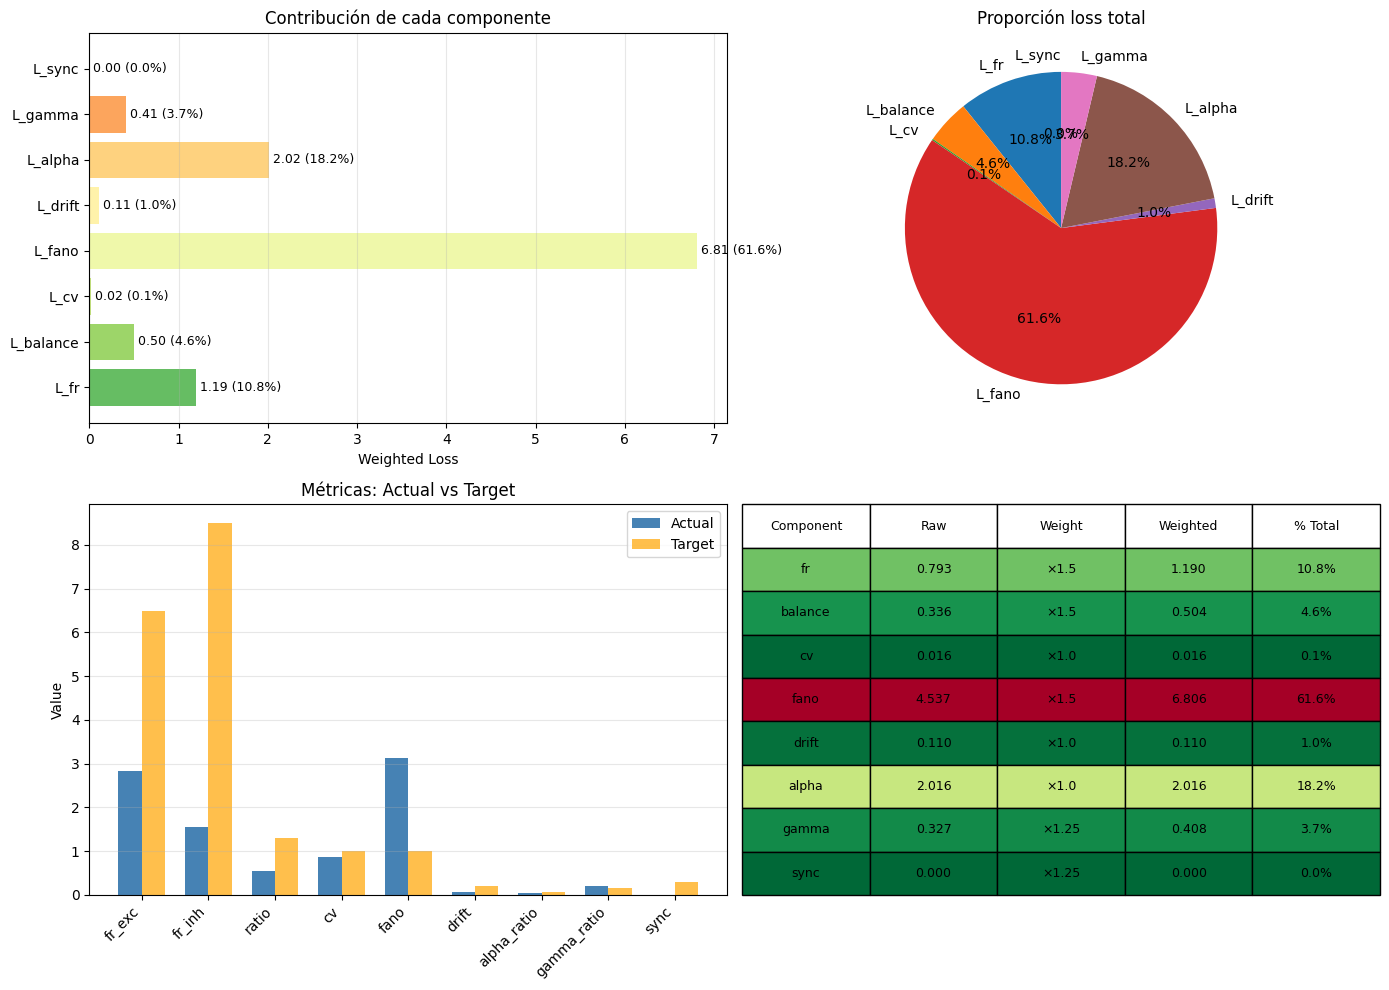


DESGLOSE COMPONENTES - MEJOR RESULTADO
Loss total: 6.489
Parámetros: rate=8.054, w_exc=0.841, w_inh=0.291

----------------------------------------------------------------------
Componente      Raw      Weight   Weighted   %Total   Status
----------------------------------------------------------------------
L_fr            0.793    ×1.5     1.190      10.8   % ⚡ Alto
L_balance       0.336    ×1.5     0.504      4.6    % ✓ OK
L_cv            0.016    ×1.0     0.016      0.1    % ✓ OK
L_fano          4.537    ×1.5     6.806      61.6   % ⚠️  CRÍTICO
L_drift         0.110    ×1.0     0.110      1.0    % ✓ OK
L_alpha         2.016    ×1.0     2.016      18.2   % ⚡ Alto
L_gamma         0.327    ×1.2     0.408      3.7    % ✓ OK
L_sync          0.000    ×1.2     0.000      0.0    % ✓ OK
----------------------------------------------------------------------
TOTAL                             11.050     100.0  %

MÉTRICAS RAW:
  fr_exc         : 2.836 (target=6.500, diff=56.4%)
  fr_inh      

In [9]:
# =============================================================================
# ANÁLISIS DE COMPONENTES DE PÉRDIDA
# =============================================================================

def analyze_loss_components_single(best_x, best_loss):
    """Analizar componentes del mejor resultado"""
    
    rate, w_exc, w_inh = best_x
    
    NETWORK_PARAMS = {
        'pop_A': {
            'Ne': 800, 'Ni': 200,
            'k_exc': 0.75, 'k_inh': 2.94,
            'noise_exc': w_exc, 'noise_inh': w_inh,
            'p_intra': 0.1, 'delay': 0.0, 'rate_hz': rate,
        }
    }
    SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 3000, 'warmup_ms': 500}
    
    results_sim, _, _ = run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial=0)
    
    # Calcular cada componente
    spike_times = results_sim['A']['spike_times']
    spike_indices = results_sim['A']['spike_indices']
    valid = spike_times >= 500
    spike_times = spike_times[valid]
    spike_indices = spike_indices[valid]
    
    Ne, Ni = 800, 200
    exc_mask = spike_indices < Ne
    inh_mask = ~exc_mask
    
    time_span_s = 2.5
    eps = 1e-8
    fr_exc = np.sum(exc_mask) / (time_span_s * Ne + eps)
    fr_inh = np.sum(inh_mask) / (time_span_s * Ni + eps)
    
    L_fr = ((fr_exc - 5.0)/5.0)**2 + ((fr_inh - 7.0)/7.0)**2
    L_balance = ((fr_inh/(fr_exc+eps) - 1.3)/1.3)**2
    
    cv = compute_cv_isi(spike_times, spike_indices, Ne+Ni, 500)
    fano = compute_fano_factor(spike_times, 3000, 100, 500)
    L_cv = ((cv - 1.0)/1.0)**2 if np.isfinite(cv) else 100
    L_fano = ((fano - 1.0)/1.0)**2 if np.isfinite(fano) else 100
    
    # Drift
    mid_time = 500 + 1250
    mask_first = (spike_times < mid_time) & exc_mask
    mask_second = (spike_times >= mid_time) & exc_mask
    fr_first = np.sum(mask_first) / (1.25 * Ne + eps)
    fr_second = np.sum(mask_second) / (1.25 * Ne + eps)
    drift = abs(fr_first - fr_second) / ((fr_first + fr_second)/2 + eps)
    L_drift = (drift / 0.2)**2
    
    # PSD
    freqs, psd = compute_psd(spike_times, 3000, 500)
    alpha_mask = (freqs >= 8) & (freqs <= 12)
    gamma_mask = (freqs >= 40) & (freqs <= 80)
    total_mask = (freqs >= 0) & (freqs <= 100)
    
    alpha_power = np.trapz(psd[alpha_mask], freqs[alpha_mask])
    gamma_power = np.trapz(psd[gamma_mask], freqs[gamma_mask])
    total_power = np.trapz(psd[total_mask], freqs[total_mask]) + 1e-12
    
    alpha_ratio = alpha_power / total_power
    gamma_ratio = gamma_power / total_power
    
    L_alpha = (max(0, 0.15 - alpha_ratio))**2 / (0.07**2)
    L_gamma = (max(0, 0.30 - gamma_ratio))**2 / (0.15**2)
    
    sync = compute_sync_index(spike_times, spike_indices, 500)
    L_sync = max(0, sync - 0.3)**2 if np.isfinite(sync) else 1.0
    
    # Resumen
    components = {
        'L_fr': L_fr,
        'L_balance': L_balance,
        'L_cv': L_cv,
        'L_fano': L_fano,
        'L_drift': L_drift,
        'L_alpha': L_alpha,
        'L_gamma': L_gamma,
        'L_sync': L_sync
    }
    
    weights = {
        'L_fr': 1.5,
        'L_balance': 1.5,
        'L_cv': 1.0,
        'L_fano': 1.5,
        'L_drift': 1.0,
        'L_alpha': 1.0,
        'L_gamma': 1.25,
        'L_sync': 1.25
    }
    
            
    # Métricas raw
    metrics = {
        'fr_exc': fr_exc,
        'fr_inh': fr_inh,
        'ratio': fr_inh/(fr_exc+eps),
        'cv': cv,
        'fano': fano,
        'drift': drift,
        'alpha_ratio': alpha_ratio,
        'gamma_ratio': gamma_ratio,
        'sync': sync
    }
    
    return components, weights, metrics

# Analizar mejor resultado
components, weights, metrics = analyze_loss_components_single(best_x, best_loss)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Contribución por componente
ax = axes[0, 0]
comp_names = list(components.keys())
weighted_vals = [components[k] * weights[k] for k in comp_names]
total = sum(weighted_vals)

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comp_names)))
bars = ax.barh(comp_names, weighted_vals, color=colors)
ax.set_xlabel('Weighted Loss')
ax.set_title('Contribución de cada componente')
ax.grid(alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, weighted_vals)):
    pct = val/total*100
    ax.text(val, i, f' {val:.2f} ({pct:.1f}%)', va='center', fontsize=9)

# 2. Pie chart contribución
ax = axes[0, 1]
ax.pie(weighted_vals, labels=comp_names, autopct='%1.1f%%', startangle=90)
ax.set_title('Proporción loss total')

# 3. Métricas vs targets
ax = axes[1, 0]
targets = {
    'fr_exc': 6.5,
    'fr_inh': 8.5,
    'ratio': 1.3,
    'cv': 1.0,
    'fano': 1.0,
    'drift': 0.2,
    'alpha_ratio': 0.07,
    'gamma_ratio': 0.15,
    'sync': 0.3
}

metric_names = list(metrics.keys())
actual = [metrics[k] for k in metric_names]
target = [targets[k] for k in metric_names]

x = np.arange(len(metric_names))
width = 0.35

bars1 = ax.bar(x - width/2, actual, width, label='Actual', color='steelblue')
bars2 = ax.bar(x + width/2, target, width, label='Target', color='orange', alpha=0.7)

ax.set_ylabel('Value')
ax.set_title('Métricas: Actual vs Target')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# 4. Tabla resumen
ax = axes[1, 1]
ax.axis('off')

table_data = []
for k in comp_names:
    table_data.append([
        k.replace('L_', ''),
        f"{components[k]:.3f}",
        f"×{weights[k]}",
        f"{components[k]*weights[k]:.3f}",
        f"{components[k]*weights[k]/total*100:.1f}%"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Component', 'Raw', 'Weight', 'Weighted', '% Total'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colorear filas por contribución
for i in range(len(comp_names)):
    pct = components[comp_names[i]]*weights[comp_names[i]]/total
    color = plt.cm.RdYlGn_r(pct * 2)  # Escalar para visualización
    for j in range(5):
        table[(i+1, j)].set_facecolor(color)

plt.tight_layout()
plt.savefig('optimization_results/best_loss_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

# Resumen texto
print("\n" + "="*70)
print("DESGLOSE COMPONENTES - MEJOR RESULTADO")
print("="*70)
print(f"Loss total: {best_loss:.3f}")
print(f"Parámetros: rate={best_x[0]:.3f}, w_exc={best_x[1]:.3f}, w_inh={best_x[2]:.3f}")
print("\n" + "-"*70)
print(f"{'Componente':<15} {'Raw':<8} {'Weight':<8} {'Weighted':<10} {'%Total':<8} {'Status'}")
print("-"*70)

for k in comp_names:
    raw = components[k]
    w = weights[k]
    weighted = raw * w
    pct = weighted/total*100
    
    # Status basado en contribución
    if pct > 20:
        status = "⚠️  CRÍTICO"
    elif pct > 10:
        status = "⚡ Alto"
    else:
        status = "✓ OK"
    
    print(f"{k:<15} {raw:<8.3f} ×{w:<7.1f} {weighted:<10.3f} {pct:<7.1f}% {status}")

print("-"*70)
print(f"{'TOTAL':<15} {'':<8} {'':<8} {total:<10.3f} {100.0:<7.1f}%")
print("="*70)

print("\nMÉTRICAS RAW:")
for k, v in metrics.items():
    target_val = targets[k]
    diff = abs(v - target_val)
    pct_diff = diff/target_val*100
    print(f"  {k:<15}: {v:.3f} (target={target_val:.3f}, diff={pct_diff:.1f}%)")

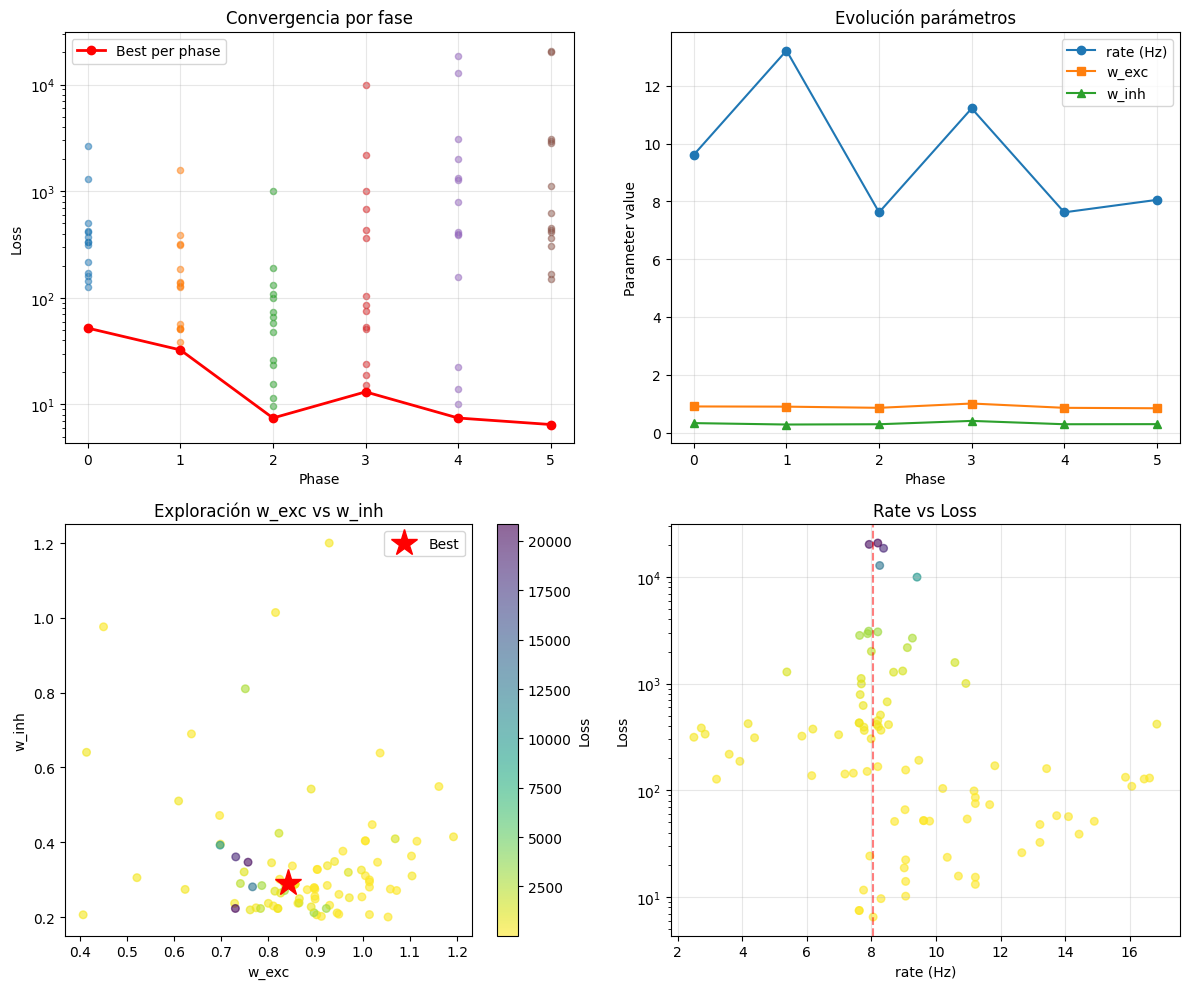

WARNING    /tmp/ipykernel_16092/3871494898.py:76: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"Evaluaciones totales: {sum(len(r.func_vals) for r in results)}")
 [py.warnings]



RESUMEN OPTIMIZACIÓN
Mejor parámetros: rate=8.054, w_exc=0.841, w_inh=0.291
Mejor loss: 6.489

Fases ejecutadas: 6
Evaluaciones totales: 90
Loss mínima encontrada: 6.489
Mejora total: 52.039 → 6.489 (87.5%)


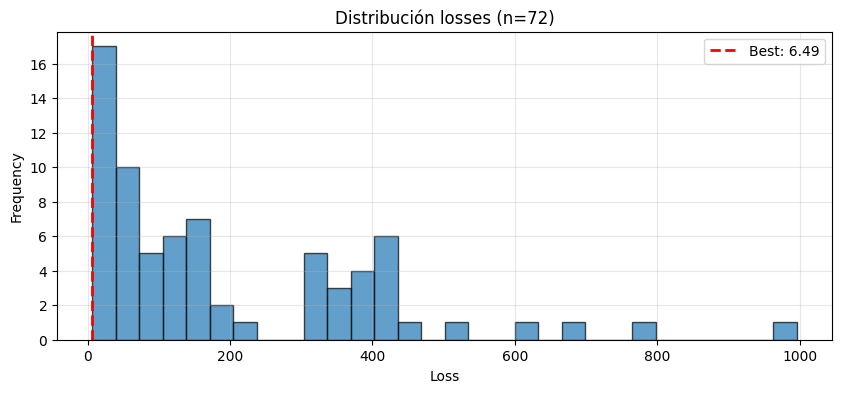


SENSIBILIDAD ESTIMADA
rate    : ρ=+0.557 (p=0.0011)
w_exc   : ρ=+0.013 (p=0.9433)
w_inh   : ρ=-0.067 (p=0.7204)


In [10]:
# =============================================================================
# ANÁLISIS POST-OPTIMIZACIÓN
# =============================================================================

def analyze_optimization_results(best_x, best_loss, results):
    """Analizar convergencia y calidad del óptimo"""
    
    # 1. Convergencia por fase
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss por fase
    ax = axes[0, 0]
    all_losses = []
    phase_labels = []
    for i, res in enumerate(results):
        losses = res.func_vals
        all_losses.extend(losses)
        phase_labels.extend([i]*len(losses))
        ax.scatter([i]*len(losses), losses, alpha=0.5, s=20)
    ax.plot([res.fun for res in results], 'r-o', linewidth=2, label='Best per phase')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_title('Convergencia por fase')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Parámetros óptimos por fase
    ax = axes[0, 1]
    rates = [res.x[0] for res in results]
    w_excs = [res.x[1] for res in results]
    w_inhs = [res.x[2] for res in results]
    ax.plot(rates, 'o-', label='rate (Hz)')
    ax.plot(w_excs, 's-', label='w_exc')
    ax.plot(w_inhs, '^-', label='w_inh')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Parameter value')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_title('Evolución parámetros')
    
    # Exploración 2D: w_exc vs w_inh
    ax = axes[1, 0]
    all_x = np.array([x for res in results for x in res.x_iters])
    all_y = np.array([y for res in results for y in res.func_vals])
    scatter = ax.scatter(all_x[:, 1], all_x[:, 2], c=all_y, 
                        cmap='viridis_r', alpha=0.6, s=30)
    ax.plot(best_x[1], best_x[2], 'r*', markersize=20, label='Best')
    ax.set_xlabel('w_exc')
    ax.set_ylabel('w_inh')
    ax.set_title('Exploración w_exc vs w_inh')
    ax.legend()
    plt.colorbar(scatter, ax=ax, label='Loss')
    
    # Exploración: rate vs loss
    ax = axes[1, 1]
    ax.scatter(all_x[:, 0], all_y, alpha=0.6, s=30, c=all_y, cmap='viridis_r')
    ax.axvline(best_x[0], color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('rate (Hz)')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_title('Rate vs Loss')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('optimization_results/analysis_convergence.png', dpi=150)
    plt.show()
    
    # 2. Estadísticas finales
    print("\n" + "="*60)
    print("RESUMEN OPTIMIZACIÓN")
    print("="*60)
    print(f"Mejor parámetros: rate={best_x[0]:.3f}, w_exc={best_x[1]:.3f}, w_inh={best_x[2]:.3f}")
    print(f"Mejor loss: {best_loss:.3f}")
    print(f"\nFases ejecutadas: {len(results)}")
    print(f"Evaluaciones totales: {sum(len(r.func_vals) for r in results)}")
    print(f"Loss mínima encontrada: {min(r.fun for r in results):.3f}")
    print(f"Mejora total: {results[0].fun:.3f} → {best_loss:.3f} ({(1-best_loss/results[0].fun)*100:.1f}%)")
    
    # 3. Distribución de losses
    fig, ax = plt.subplots(figsize=(10, 4))
    valid_losses = [l for l in all_losses if l < 1000]
    if valid_losses:
        ax.hist(valid_losses, bins=30, alpha=0.7, edgecolor='k')
        ax.axvline(best_loss, color='r', linestyle='--', linewidth=2, label=f'Best: {best_loss:.2f}')
        ax.set_xlabel('Loss')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribución losses (n={len(valid_losses)})')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.savefig('optimization_results/loss_distribution.png', dpi=150)
        plt.show()
    
    # 4. Sensibilidad: ¿qué parámetros importan más?
    print("\n" + "="*60)
    print("SENSIBILIDAD ESTIMADA")
    print("="*60)
    valid_mask = np.array(all_y) < 100
    if np.sum(valid_mask) > 10:
        from scipy.stats import spearmanr
        for i, name in enumerate(['rate', 'w_exc', 'w_inh']):
            corr, pval = spearmanr(all_x[valid_mask, i], np.array(all_y)[valid_mask])
            print(f"{name:8s}: ρ={corr:+.3f} (p={pval:.4f})")

# Usar después de optimización
analyze_optimization_results(best_x, best_loss, results)

In [11]:
# Diagnóstico rápido
def diagnose_optimization(results):
    all_losses = [l for res in results for l in res.func_vals]
    
    print("DIAGNÓSTICO:")
    print(f"1. ¿Muchos fallos? {np.sum(np.array(all_losses) >= 1e5)} / {len(all_losses)}")
    print(f"2. ¿Converge? Std últimas 20: {np.std(all_losses[-20:]):.2f}")
    print(f"3. ¿Loss razonable? Min={min(all_losses):.2f}, Median={np.median(all_losses):.2f}")
    print(f"4. ¿Explora bien? Unique losses: {len(np.unique(all_losses))}")
    
    if min(all_losses) > 50:
        print("\n⚠️ PROBLEMA: Loss muy alta, revisar:")
        print("  - Targets demasiado estrictos")
        print("  - Pesos desequilibrados")
        print("  - Rangos de búsqueda incorrectos")

diagnose_optimization(results)

DIAGNÓSTICO:
1. ¿Muchos fallos? 0 / 90
2. ¿Converge? Std últimas 20: 6018.10
3. ¿Loss razonable? Min=6.49, Median=178.61
4. ¿Explora bien? Unique losses: 87


=== Resultado final adaptativo ===
Mejor x: [1.5124835379872539, 0.6125, 0.40625]
Mejor loss: 1.5827115435143204
Parámetros óptimos adaptativos: [1.5124835379872539, 0.6125, 0.40625]
Pérdida óptima adaptativa: 1.5827115435143204

In [12]:
[res['fun'] for res in results]

[np.float64(52.038968106546605),
 np.float64(32.490539996837896),
 np.float64(7.4686645461026195),
 np.float64(13.13450237022773),
 np.float64(7.4686645461026195),
 np.float64(6.489414891457592)]

In [13]:
result = results[2]

In [14]:
# Extraer óptimo
best_params = result.x
best_rate, best_w_exc, best_w_inh = best_params
best_loss = result.fun

print(f"Óptimo: rate={best_rate:.2f} Hz, w_exc={best_w_exc:.3f}, w_inh={best_w_inh:.3f}")
print(f"Loss: {best_loss:.1f}")

# ⚠️ PROBLEMA: Loss=1e6 indica TODAS las sims fallaron
# Revisar func_vals
print(f"\nTodas las losses: {np.unique(result.func_vals)}")

# Si todas son 1e6 → debugging necesario
if np.all(result.func_vals >= 1000):
    print("❌ Todas las sims fallaron. Causas posibles:")
    print("  - FR fuera de [2,15] Hz (L_bounds)")
    print("  - Exception en simulate()")
    print("  - Rate muy bajo/alto")

Óptimo: rate=7.62 Hz, w_exc=0.856, w_inh=0.288
Loss: 7.5

Todas las losses: [   7.46866455    9.65260324   11.60953998   15.70646666   23.55387537
   26.02784654   47.84755722   57.8887786    65.8400602    73.45916719
   98.72988962  109.10627181  132.68407559  191.27794724 1005.37524741]


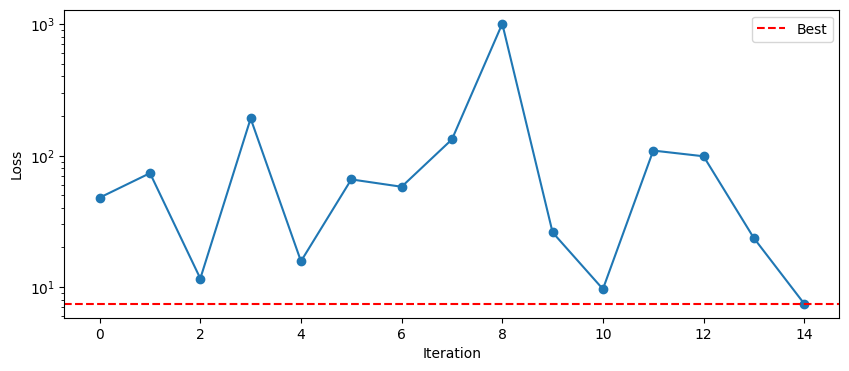

In [15]:
# Plot convergencia
losses = result.func_vals
plt.figure(figsize=(10,4))
plt.plot(losses, 'o-')
plt.axhline(best_loss, color='r', linestyle='--', label='Best')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('optimization_convergence.png')

In [16]:
# Simulation parameters
SIM_CONFIG = {
'dt_ms': 0.1,
'T_ms': 4000,
'warmup_ms': 500
}

# Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': 800, 'Ni': 200,
        'k_exc': 0.75, 'k_inh': 2.9,
        'noise_exc': 0.884, 
        'noise_inh': 0.604,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.11
    }
}

    
results, network, SIM_CONFIG = run_iteration(NETWORK_PARAMS, SIM_CONFIG, 0)

INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 4000ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 200, 'variable_base_B': 202, 'variable_base_common': 201, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 200
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.11Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO     | __main__:run_iteration:37 - 
INFO     | __main__:run_iteration:38 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:39 - =================================================

INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== Baseline (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 4.3ms
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:643 -     DEBUG: CV_individual=0.366, CV_population=0.232
INFO     | src.two_populations.metrics:print_network_statistics_table:706 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:708 - ESTADÍSTICAS DE RED - Población A (Post-warmup 500ms)
INFO     | src.two_populations.metrics:print_network_statistics_table:709 - ================================================================================
INFO     | src.two_populations.metrics:print_network_statistics_table:711 - Métrica                   Población A               Población B              
INFO     | src.two_populations.metrics:print_network_statistics_table:7

baseline: 500 monitored, 400 exc
  Plotting: [np.int64(174), np.int64(501), np.int64(329), np.int64(801), np.int64(926), np.int64(970)]


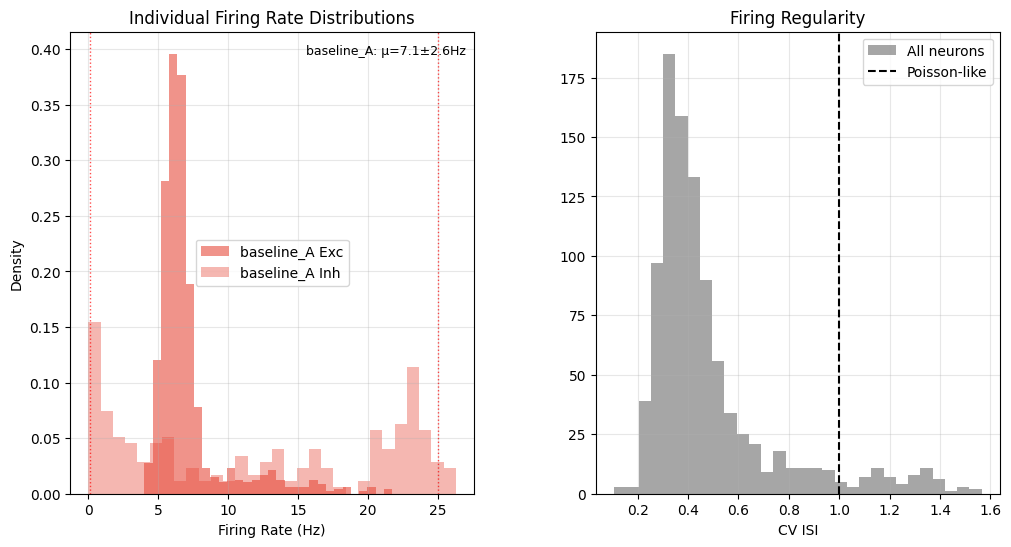

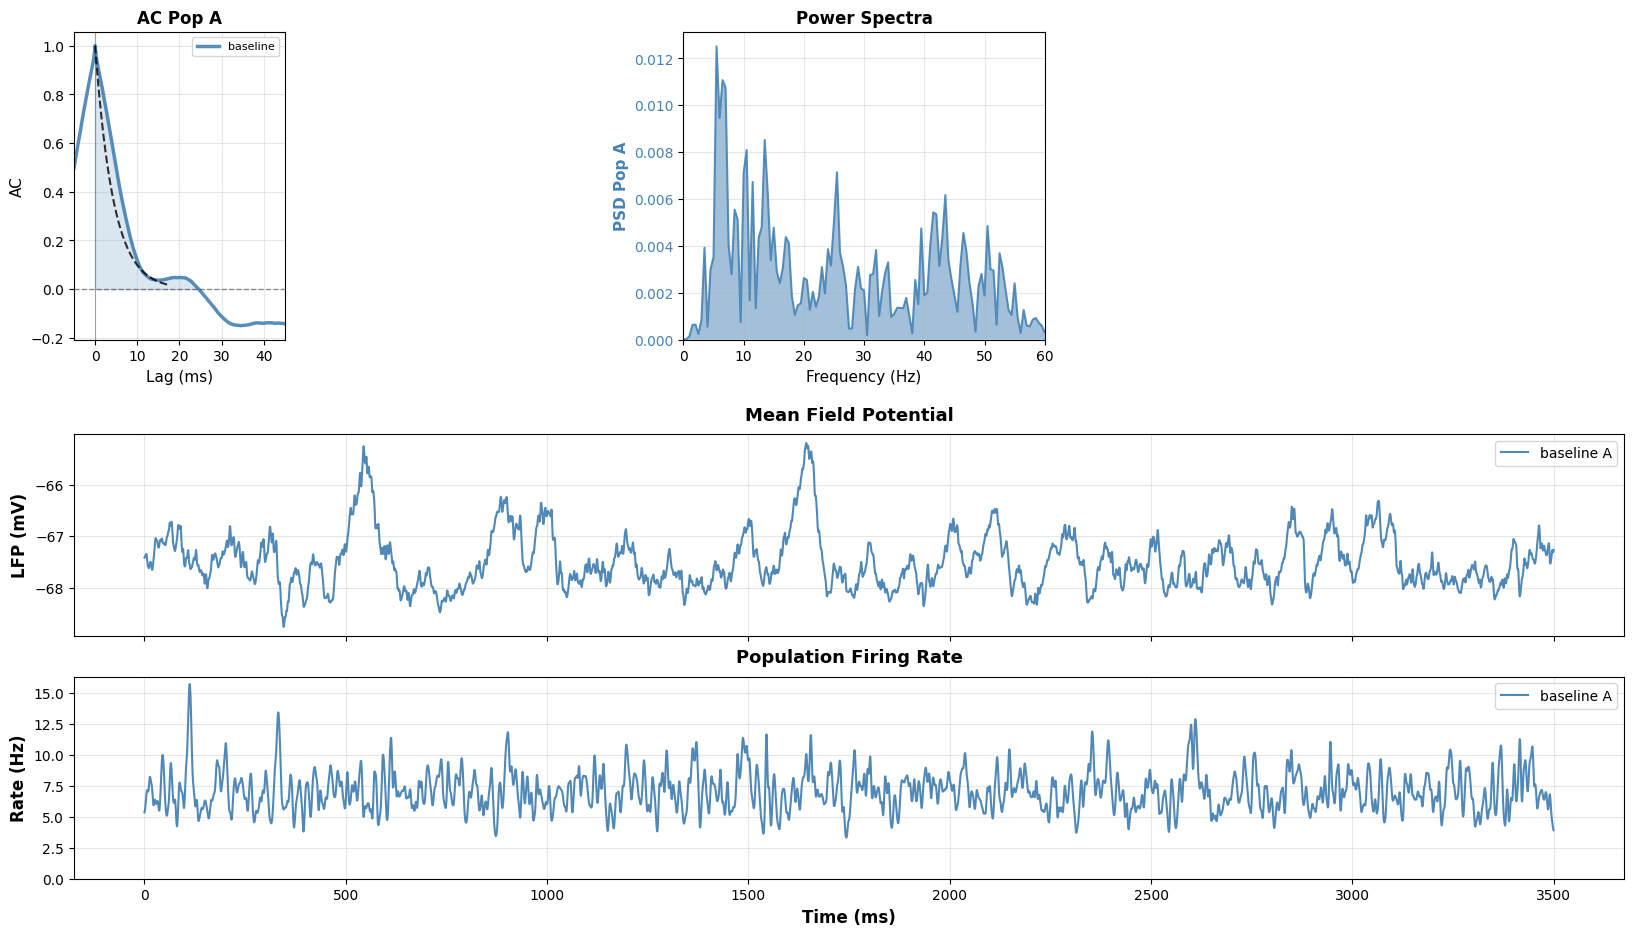

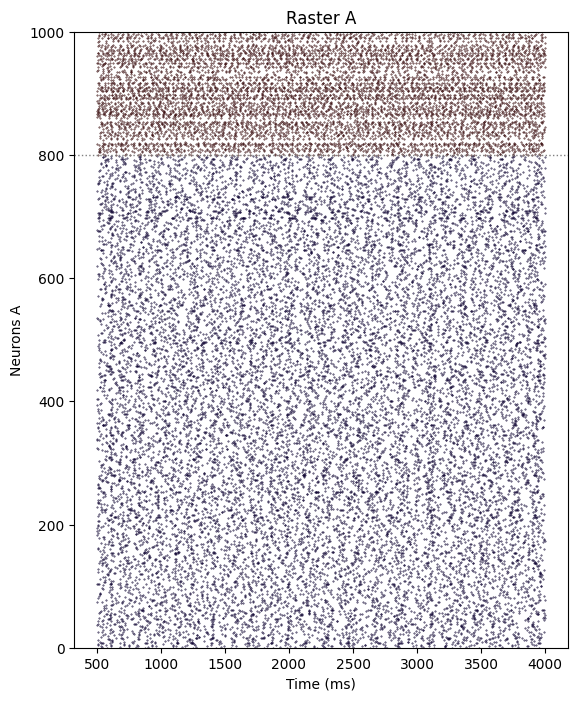

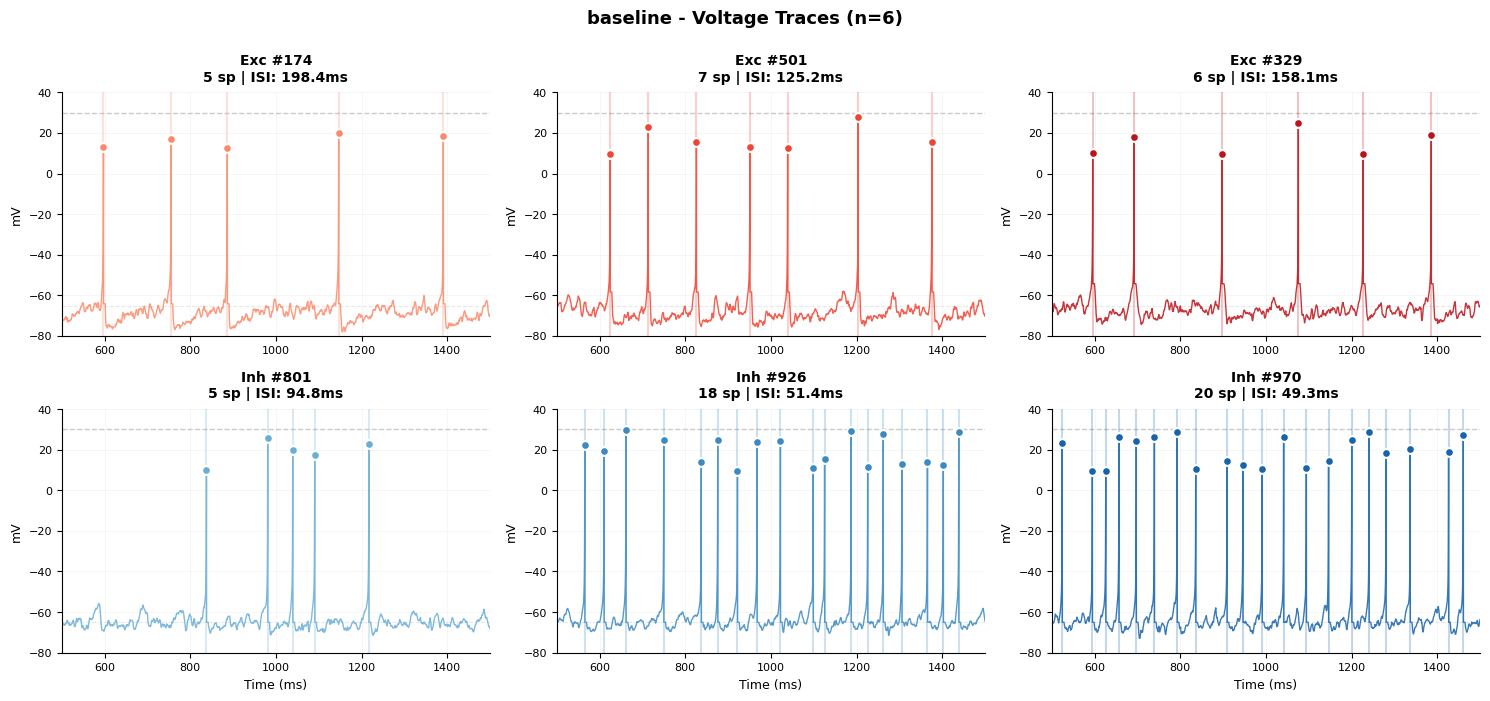

In [17]:
from src.two_populations.plots.dashboard_plots import plot_population_dashboard
from src.two_populations.plots.basic_plots import plot_raster_results, plot_voltage_traces
# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================
from src.two_populations.helpers.validator import (
    add_validation_to_analysis, 
    plot_population_validation_dashboard, 
    print_validation_summary
)
from src.two_populations.metrics import analyze_simulation_results

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        results['A']['spike_monitor'], 
        None, 
        1000, "Baseline", 
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode = 'lfp',
        T_total=SIM_CONFIG['T_ms'] # firing_rate
    )
}

# Add validation metrics
validation_results = add_validation_to_analysis(results_dict)

# Network statistics table
print_network_statistics_table(
    results, network, 
    N_exc=800, N_inh=200, 
    T_total=SIM_CONFIG['T_ms'], 
    warmup=SIM_CONFIG['warmup_ms']
)

# Dashboards
fig_val = plot_population_validation_dashboard(validation_results)
print_validation_summary(validation_results)

fig_pop = plot_population_dashboard(results_dict)
plot_raster_results(results)
plot_voltage_traces(results_dict, results, (500,1500), 3, 3, 3)
plt.show()